# Case study: CPA-catalyzed nucleophilic addition to imines (*Nature* **2019**)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import warnings

import sys
sys.path.append('../src/')
import RaRFRegressor
import utils

plt.rcParams['font.size'] = 14
COLORA = '#027F80'
COLORB = '#B2E5FC'

SEED = 314159


In [2]:
def prepare_dataset(path):

    original_df = pd.read_excel(path, sheet_name='df')
    imines = pd.read_excel(path, sheet_name='imine').set_index('Imine').to_dict(orient='index')
    ligands = pd.read_excel(path, sheet_name='ligand').set_index('ligand').to_dict(orient='index')
    solvents = pd.read_excel(path, sheet_name='solvent').set_index('solvent').to_dict(orient='index')
    nucs = pd.read_excel(path, sheet_name='nuc').set_index('Nucleophile').to_dict(orient='index')

    nuc_descriptors = []
    ligand_descriptors = []
    solvent_descriptors = []
    imine_descriptors = []

    for nuc in original_df['Nucleophile']:
        nuc_descriptors.append(nucs[nuc])

    for ligand in original_df['Ligand']:
        ligand_descriptors.append(ligands[ligand])

    for solvent in original_df['Solvent']:
        solvent_descriptors.append(solvents[solvent])

    for imine in original_df['Imine']:
        imine_descriptors.append(imines[imine])

    descriptors = pd.DataFrame.from_dict(nuc_descriptors).join(pd.DataFrame.from_dict(ligand_descriptors)).join(pd.DataFrame.from_dict(imine_descriptors)).join(pd.DataFrame.from_dict(solvent_descriptors))
    new_df = original_df.join(descriptors)

    return(new_df)

df = prepare_dataset('../data/Nature_2019.xlsx')
reduced_df = VarianceThreshold().fit_transform(df.iloc[:,6:])
df_train, df_test = train_test_split(reduced_df,train_size=0.8, random_state=25)

X_train = df_train[:,1:]
X_test = df_test[:,1:]
y_train = df_train[:,0]
y_test = df_test[:,0]

## RaRF Regression

In [3]:
def run_and_plot(radius, X_train, y_train, X_test, y_test, distances, title_extra = None):
    radius_pred, train_neighbours = RaRFRegressor.RaRFRegressor(radius=radius, metric='jaccard', seed=SEED).train_parallel(X_train,y_train, include_self='True')
    radius_testpred, test_neighbours, test_neighbours_list = RaRFRegressor.RaRFRegressor(radius=radius,metric='jaccard', seed=SEED).predict_parallel(X_train, y_train, X_test, distances)    

    test_neighbours = np.array(test_neighbours)
    nan_indexes = []
    index = -1
    for prediction in radius_testpred:
        index +=1
        if np.isnan(prediction) == True:
            nan_indexes.append(index)
        
    radius_testpred_temp = np.delete(radius_testpred,nan_indexes)
    y_test_temp = np.delete(y_test,nan_indexes)


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=300)


    ax1.plot(y_train,y_train, color='grey', zorder=0)

    train_r2 = r2_score(y_train,radius_pred)
    test_r2 = r2_score(y_test_temp,radius_testpred_temp)
    ax1.scatter(y_train,radius_pred, label='train R2 ' + str(round(train_r2,2)), color='#279383')
    ax1.scatter(y_test_temp,radius_testpred_temp, label='test R2 ' + str(round(test_r2,2)), color='white', edgecolor='#279383')

    ax1.set_xlabel('Measured $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.set_ylabel('Predicted $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.legend()


    ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])
    ax2.legend(['train', 'test'])
    ax2.set_xlim(-10,200)
    ax2.set_xlabel('# of neighbours')

    fig.suptitle(f'Radius {radius}, {len(nan_indexes)}/{len(radius_testpred)} NaNs {title_extra if title_extra else ""}')
    plt.tight_layout()
    plt.show()

    flattened_list = [item for sublist in test_neighbours_list for item in sublist]

    reaction_set = set(flattened_list)


    return (mean_absolute_error(y_test_temp,radius_testpred_temp)), len(nan_indexes), np.average([test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]), reaction_set, test_neighbours_list, test_r2


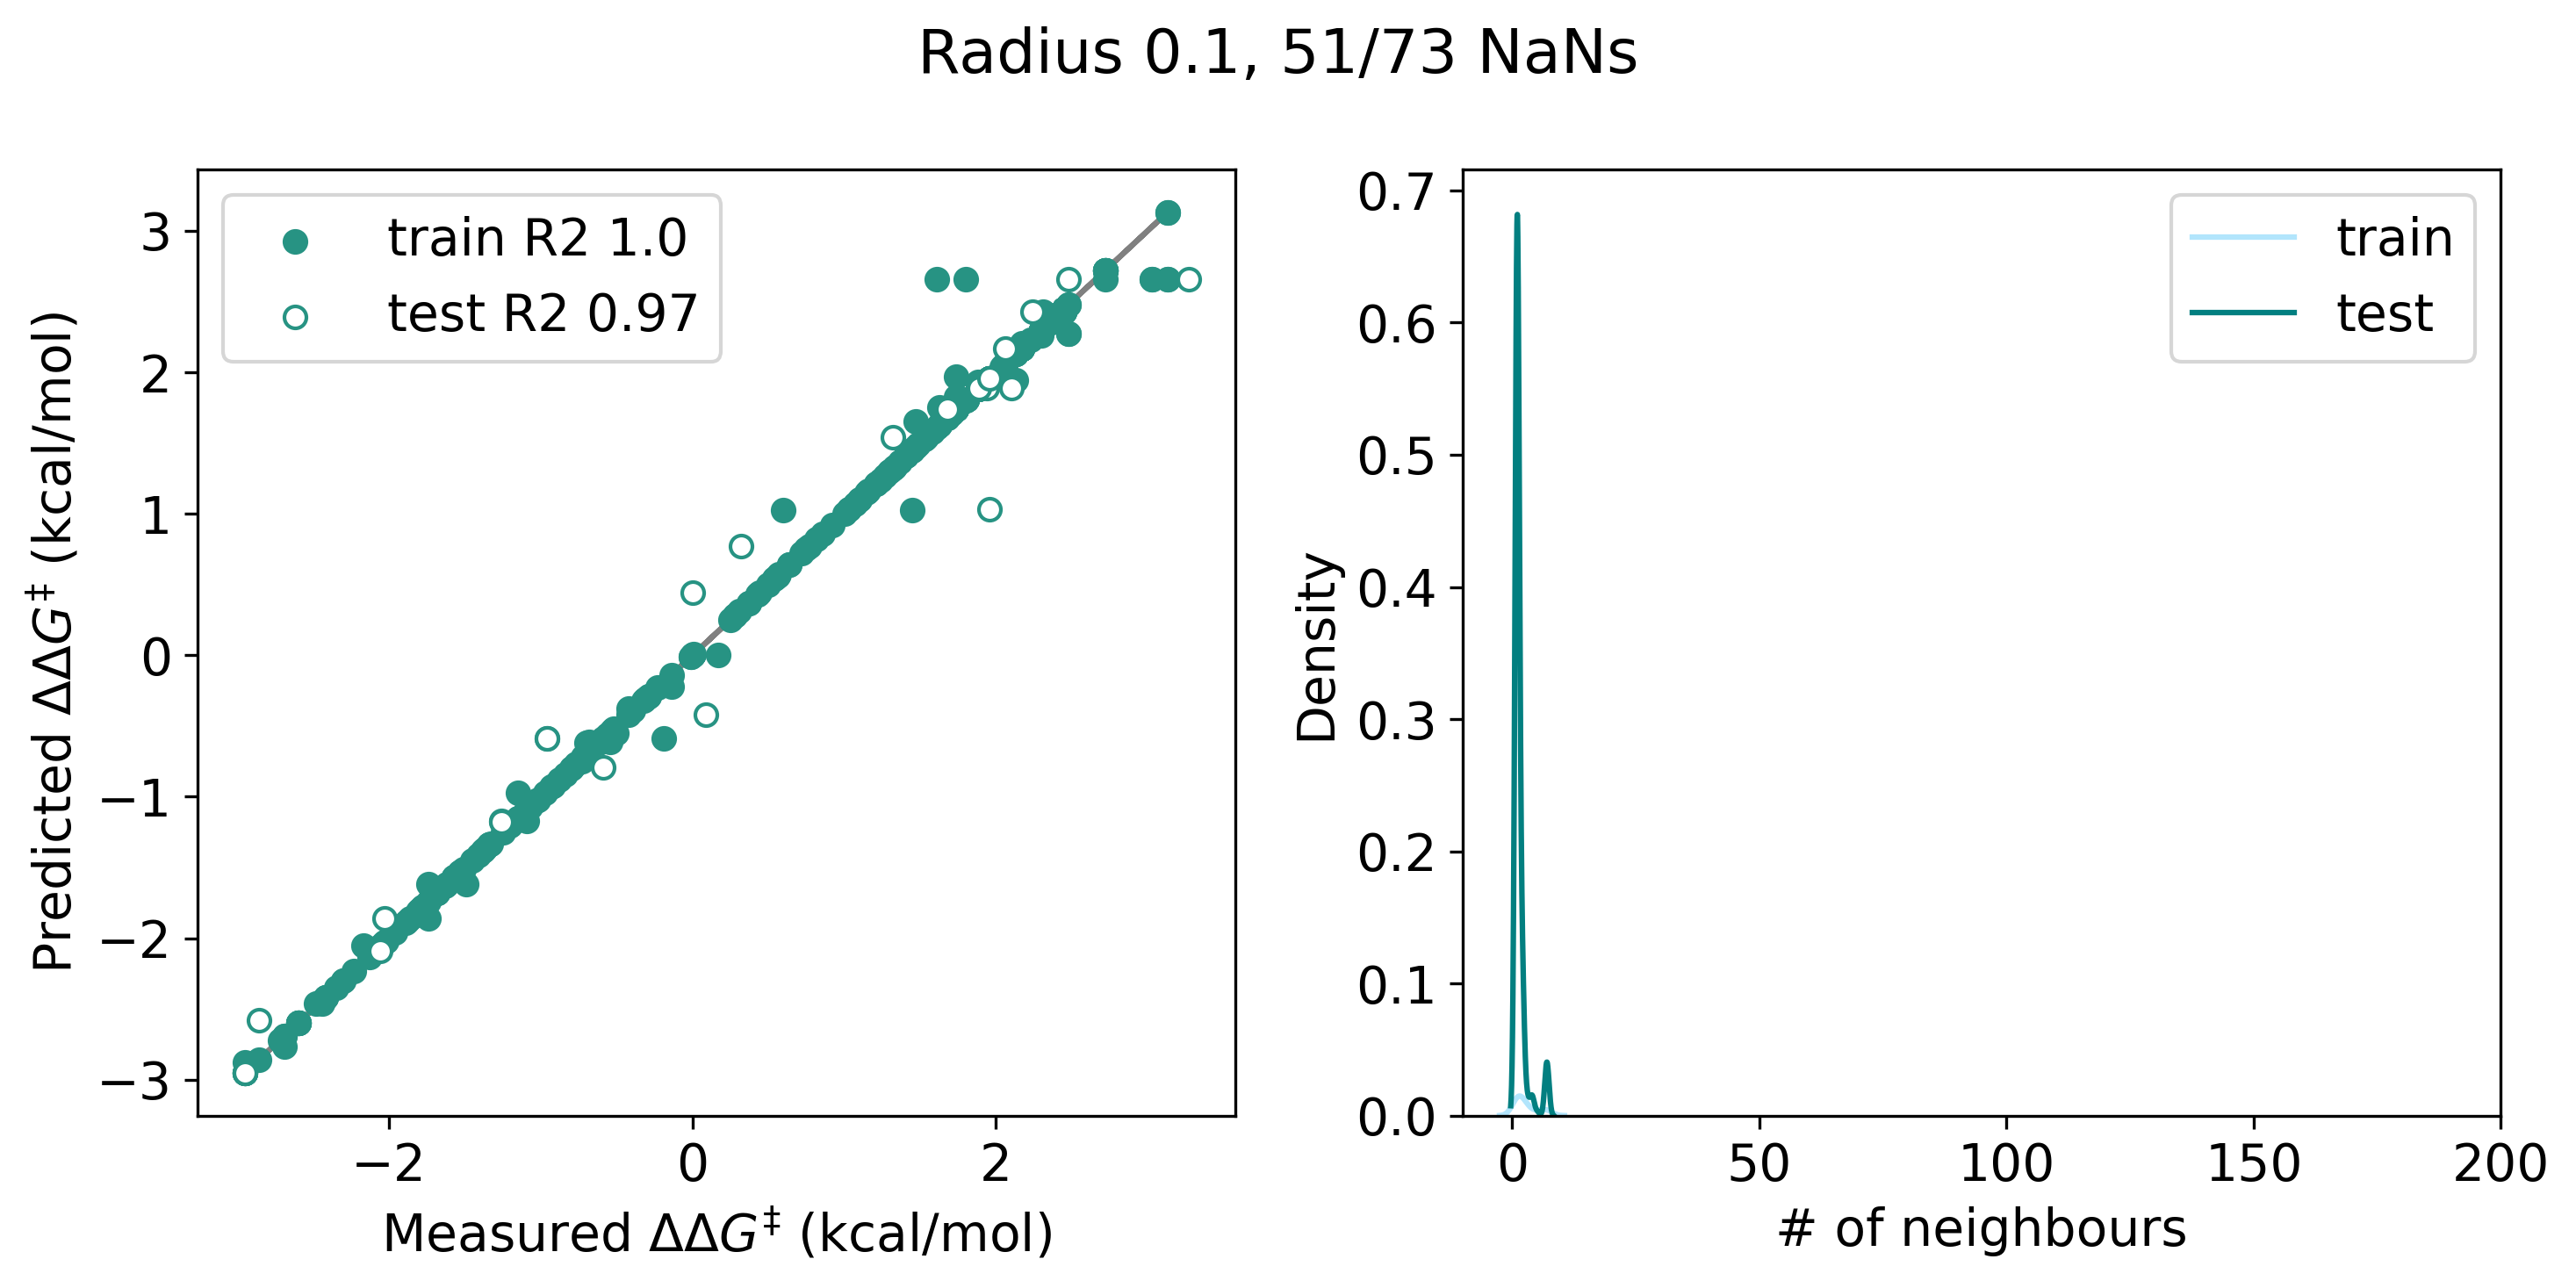

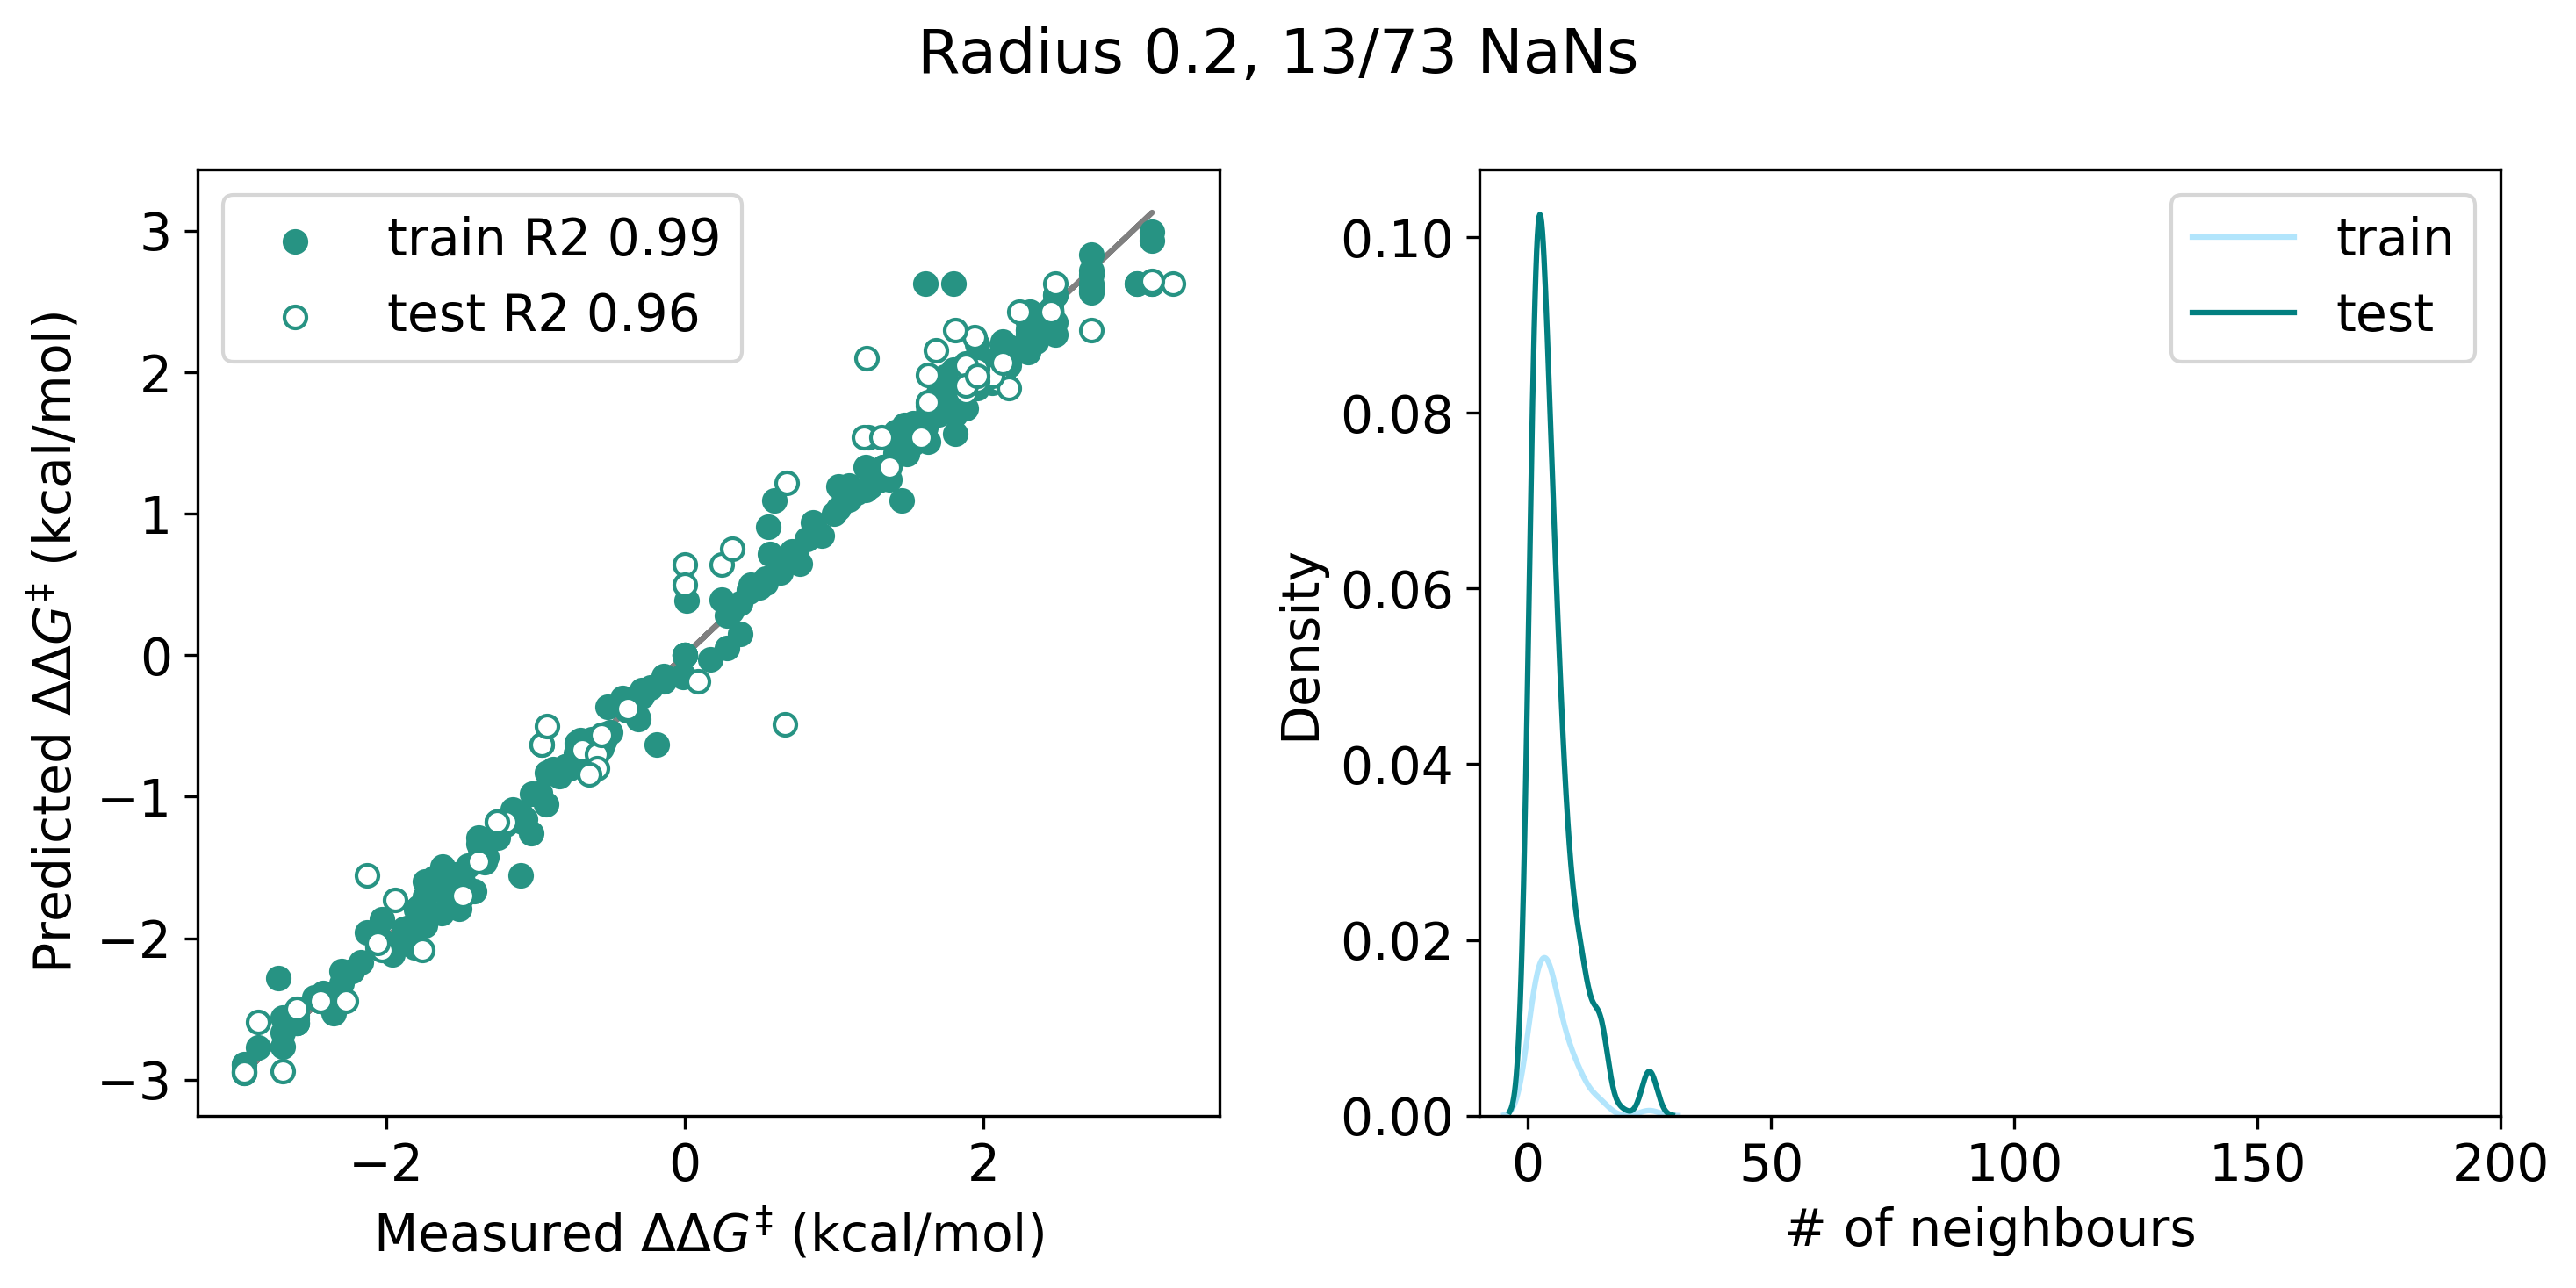

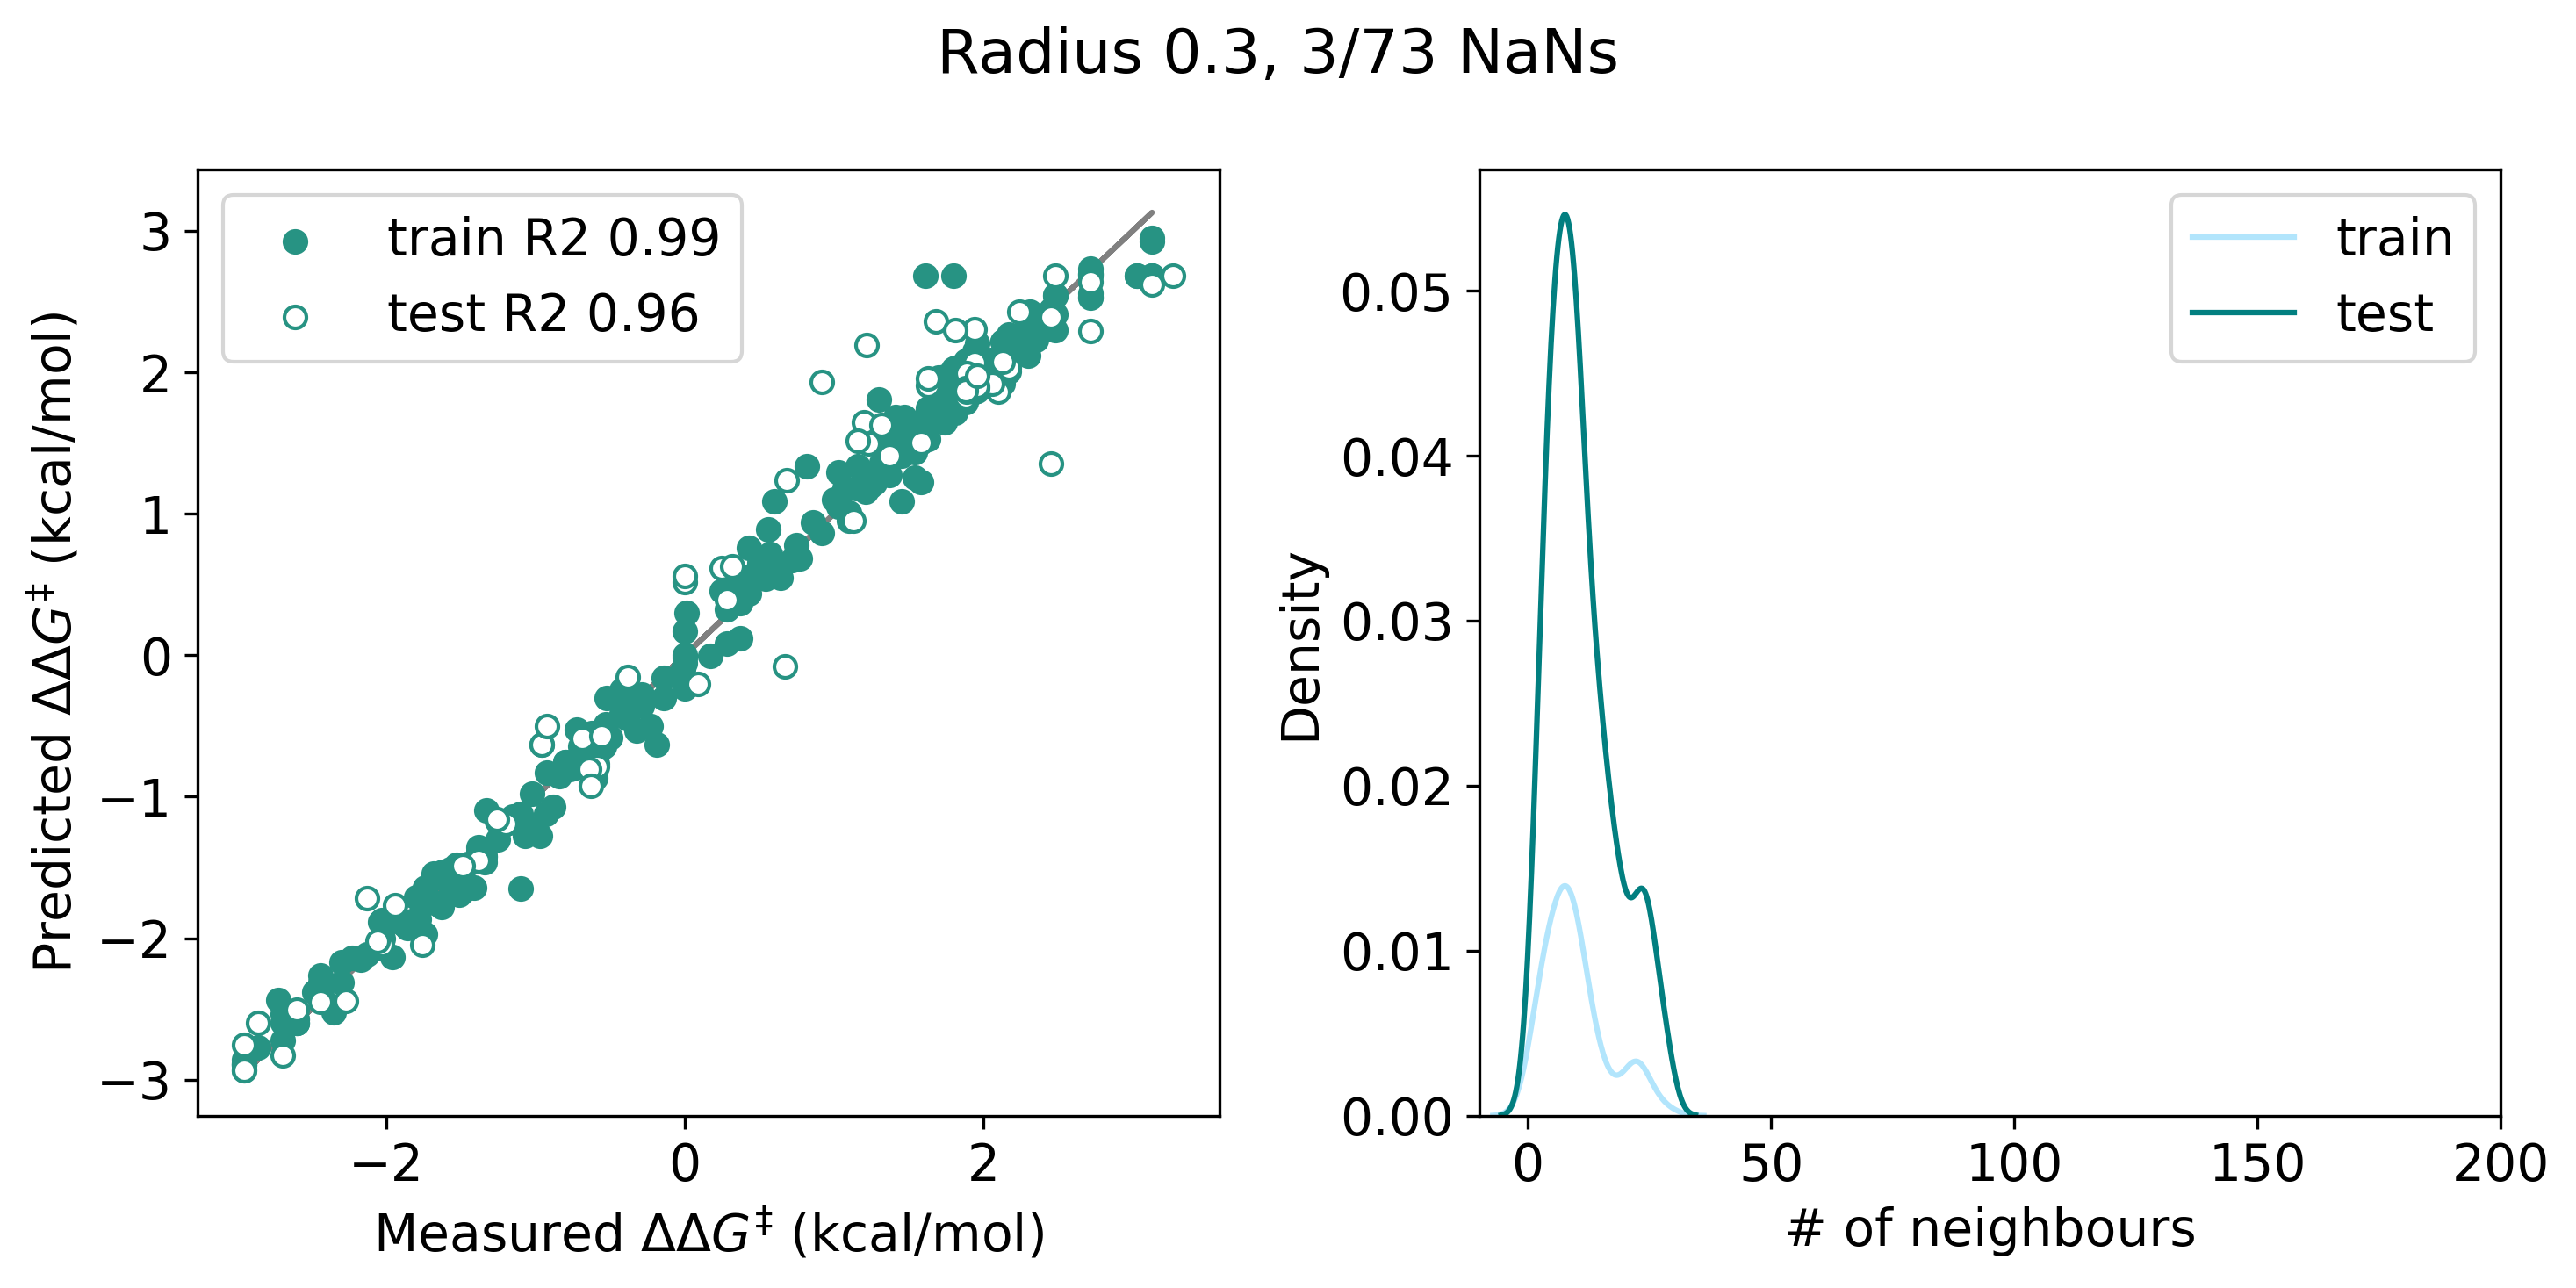

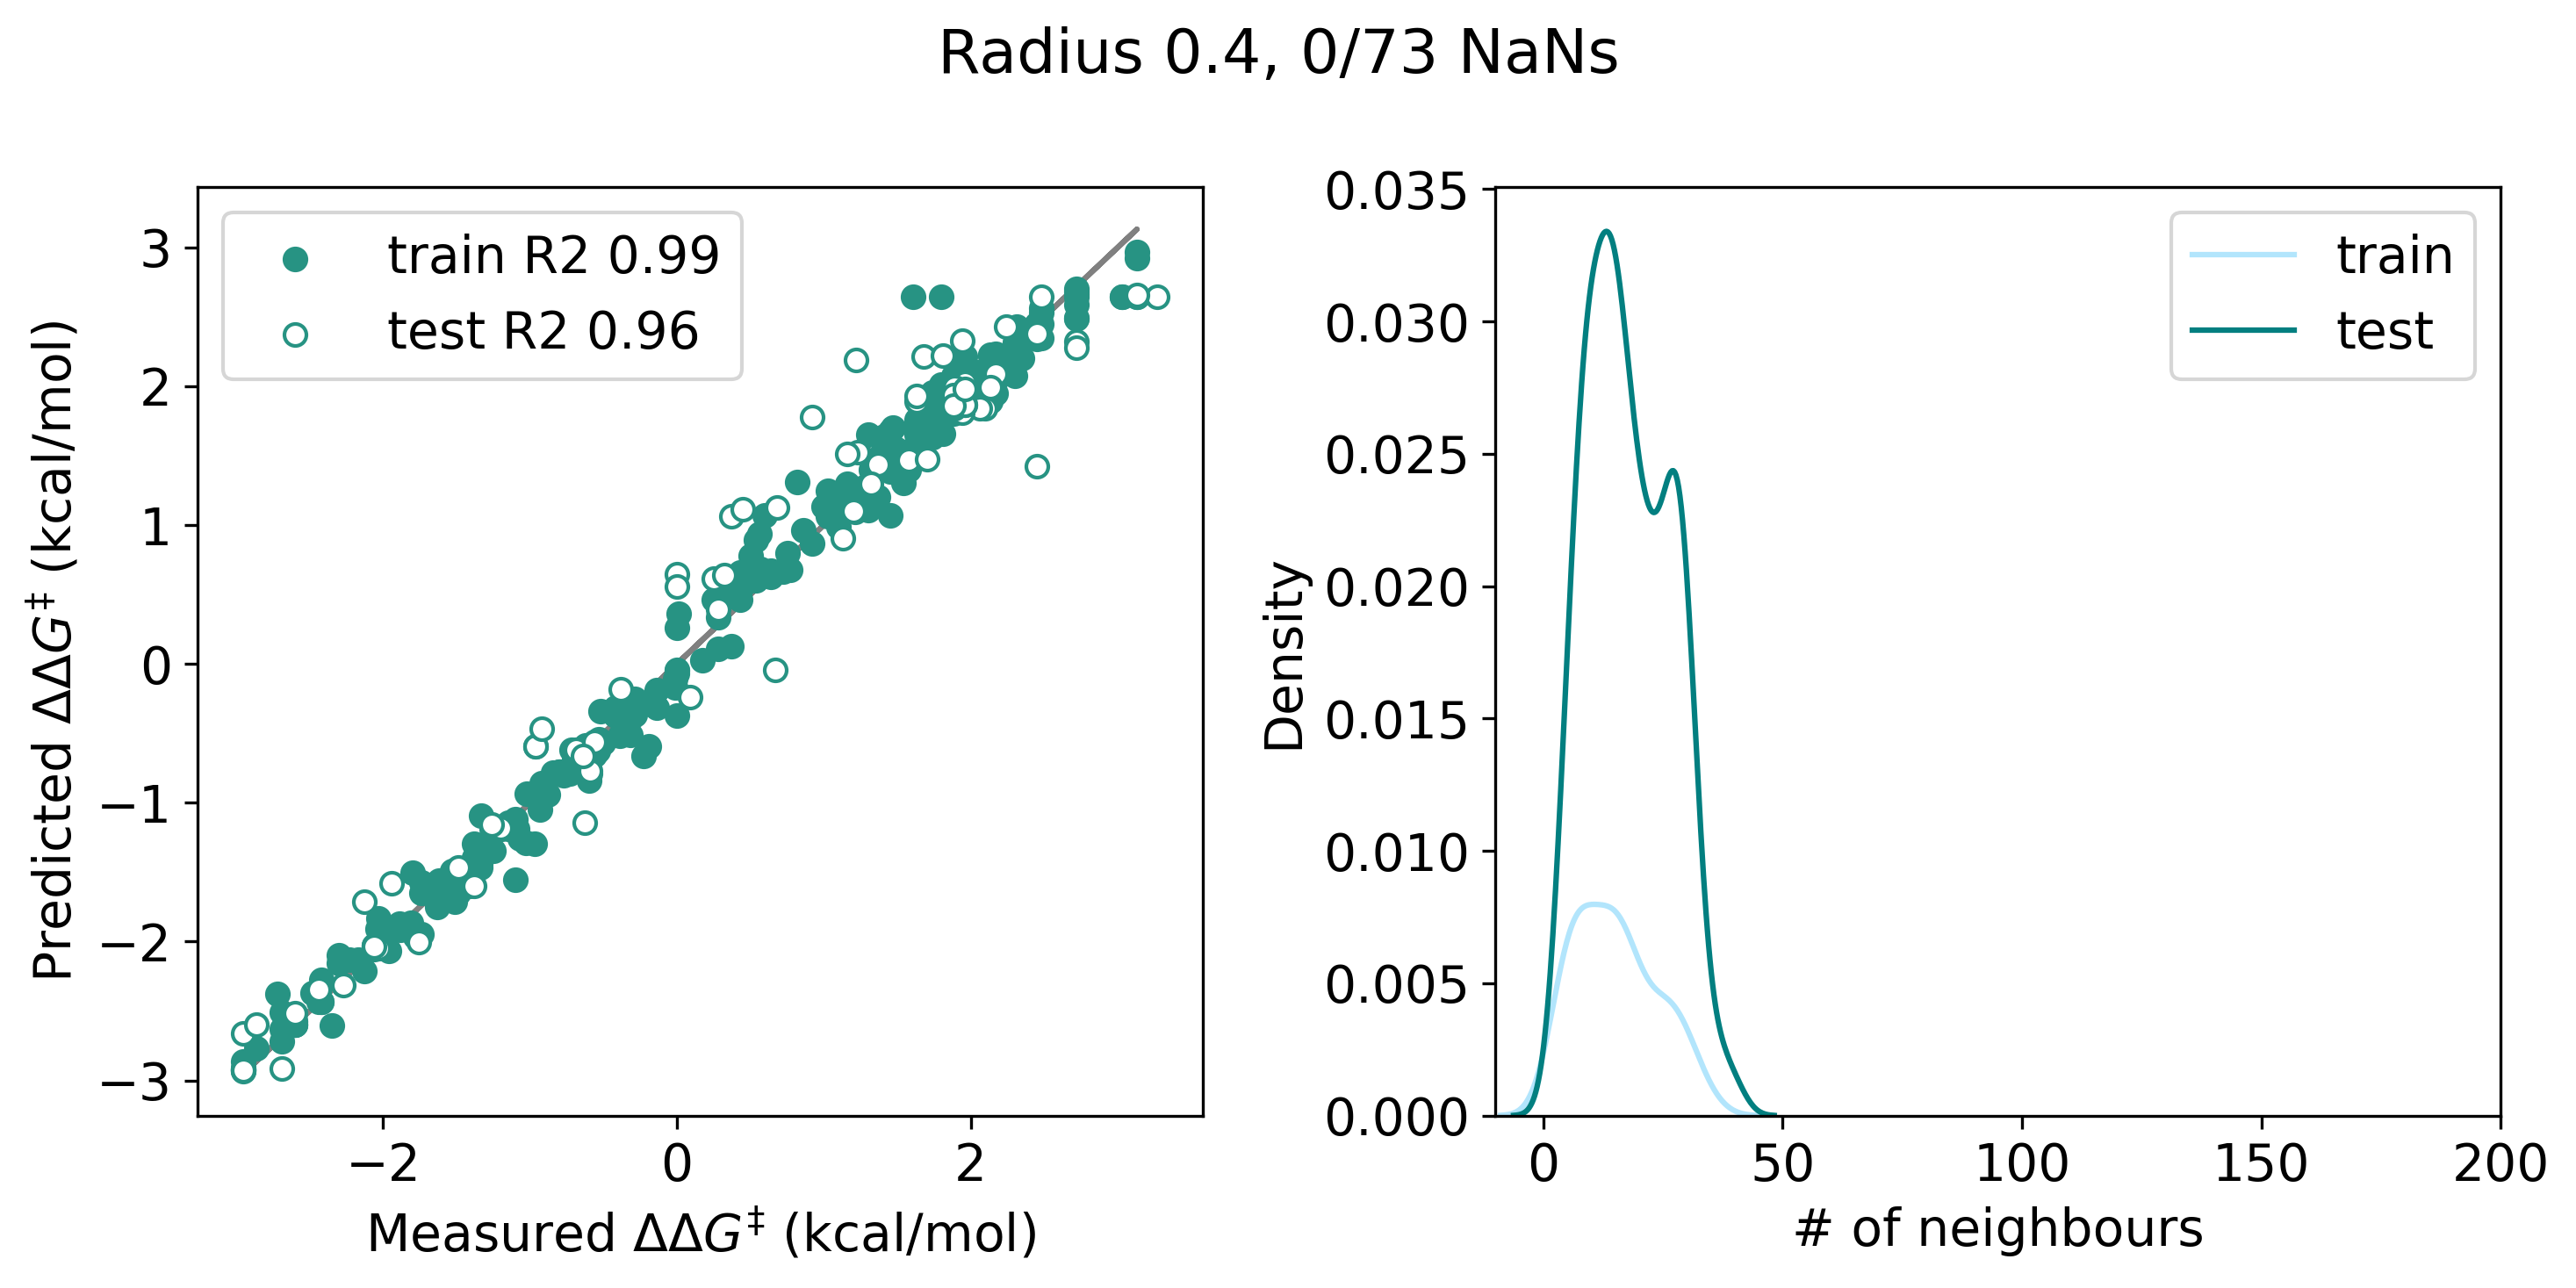

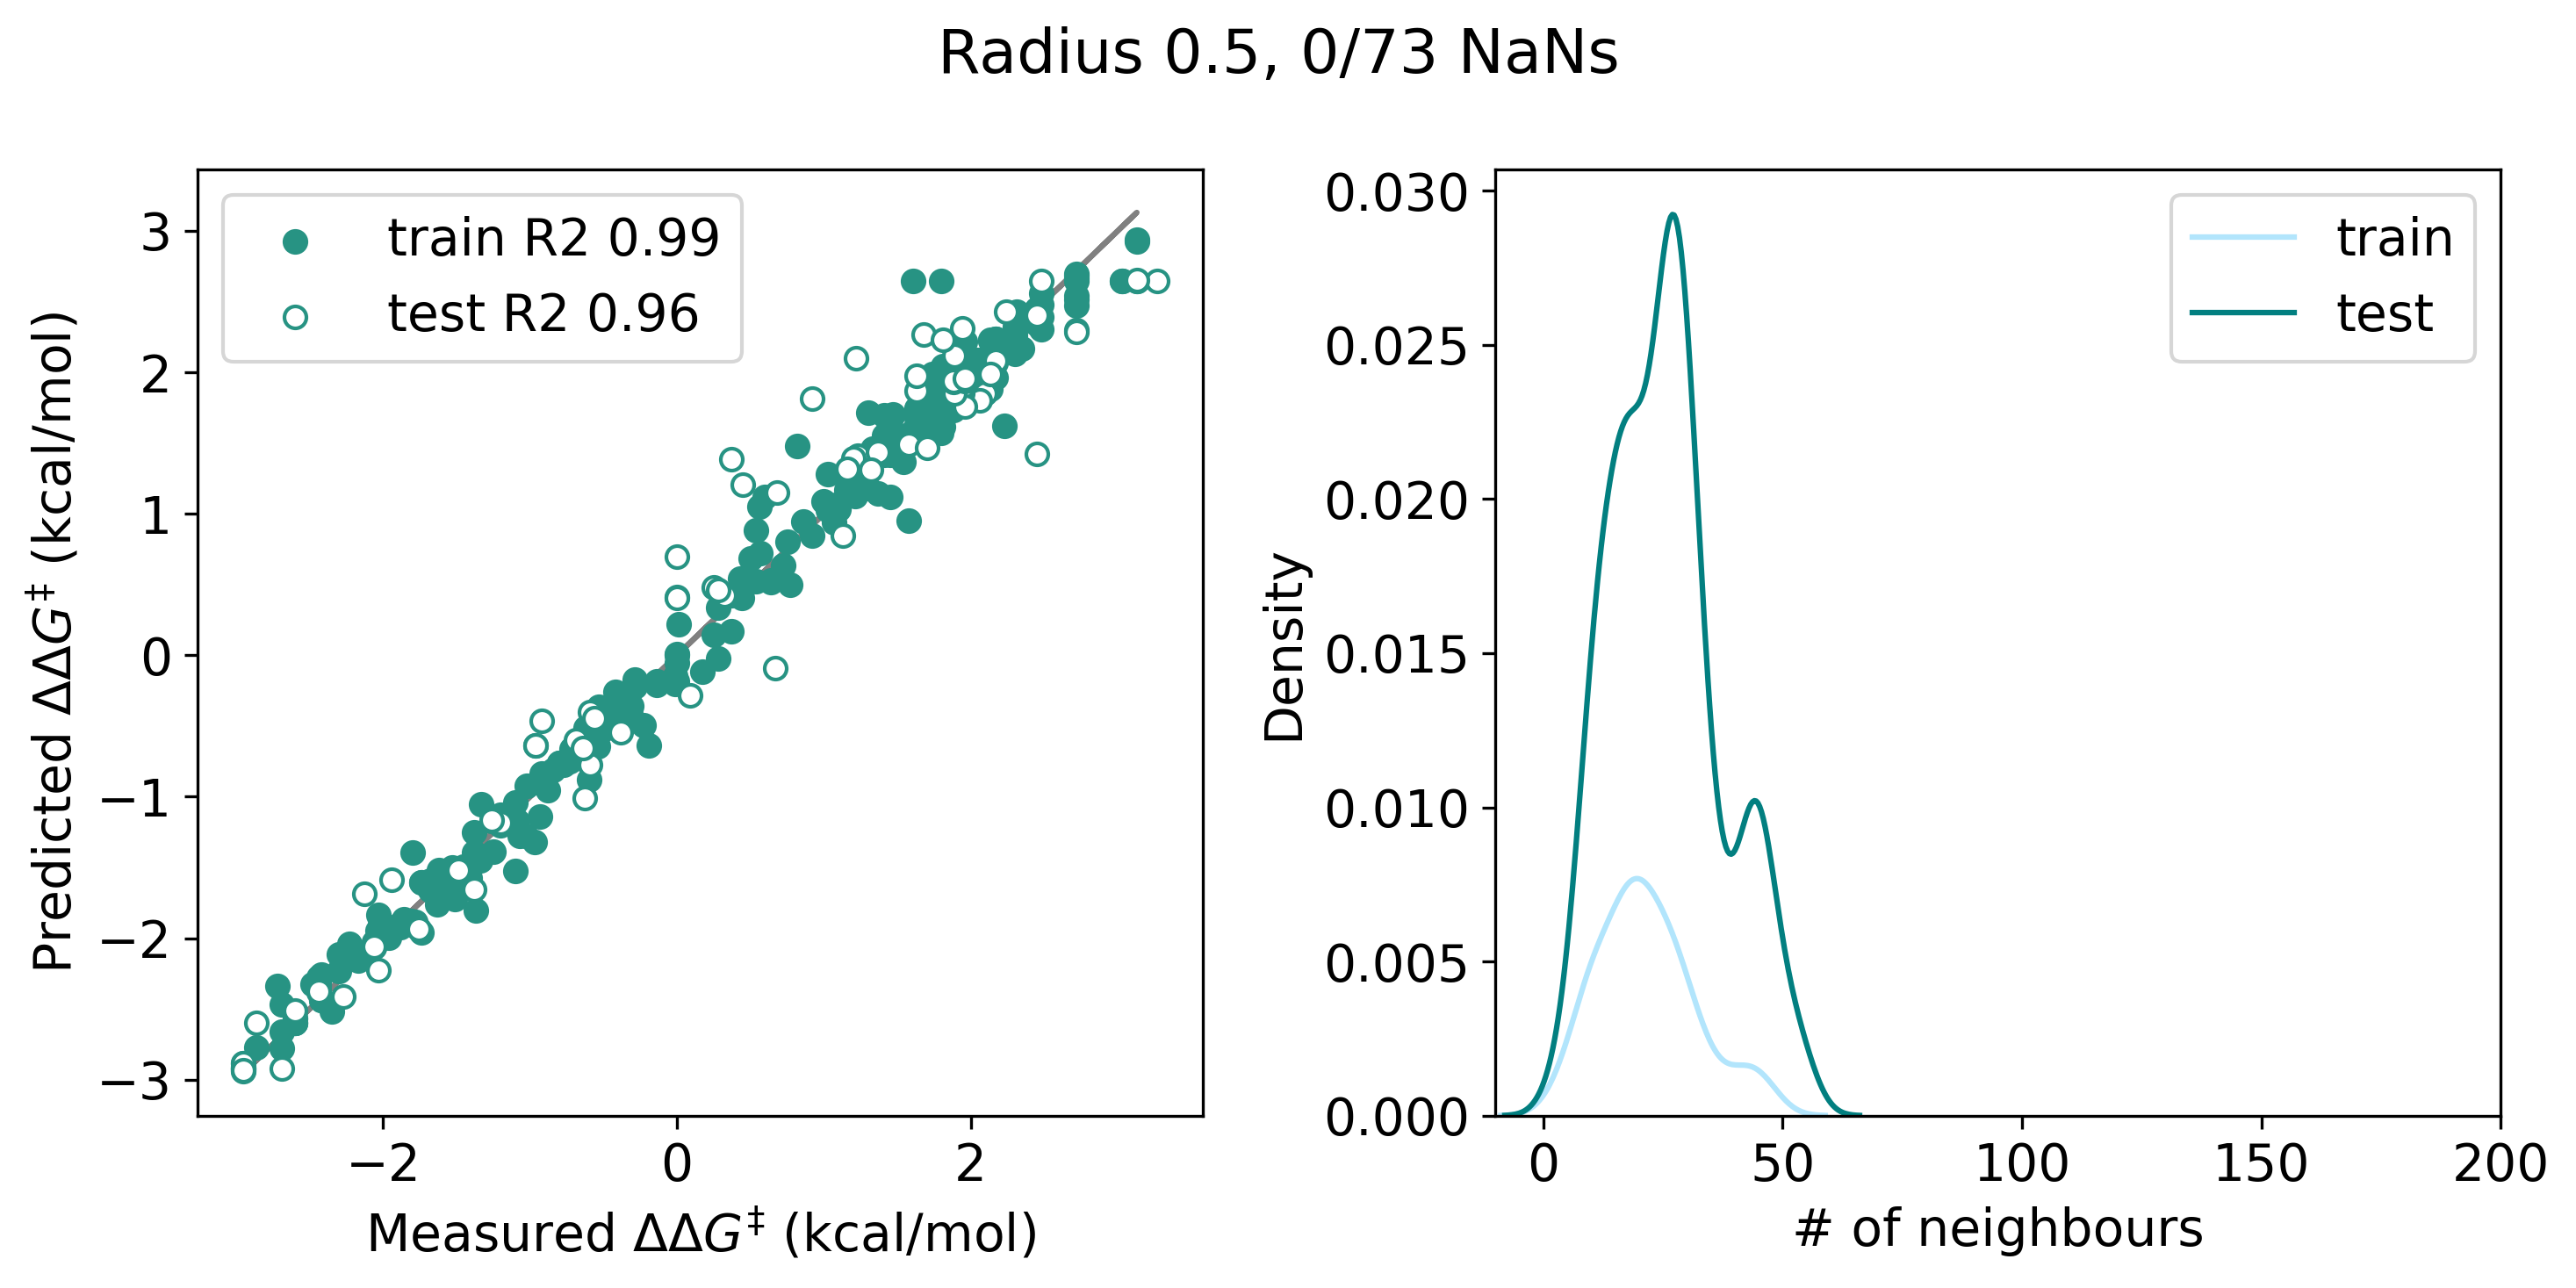

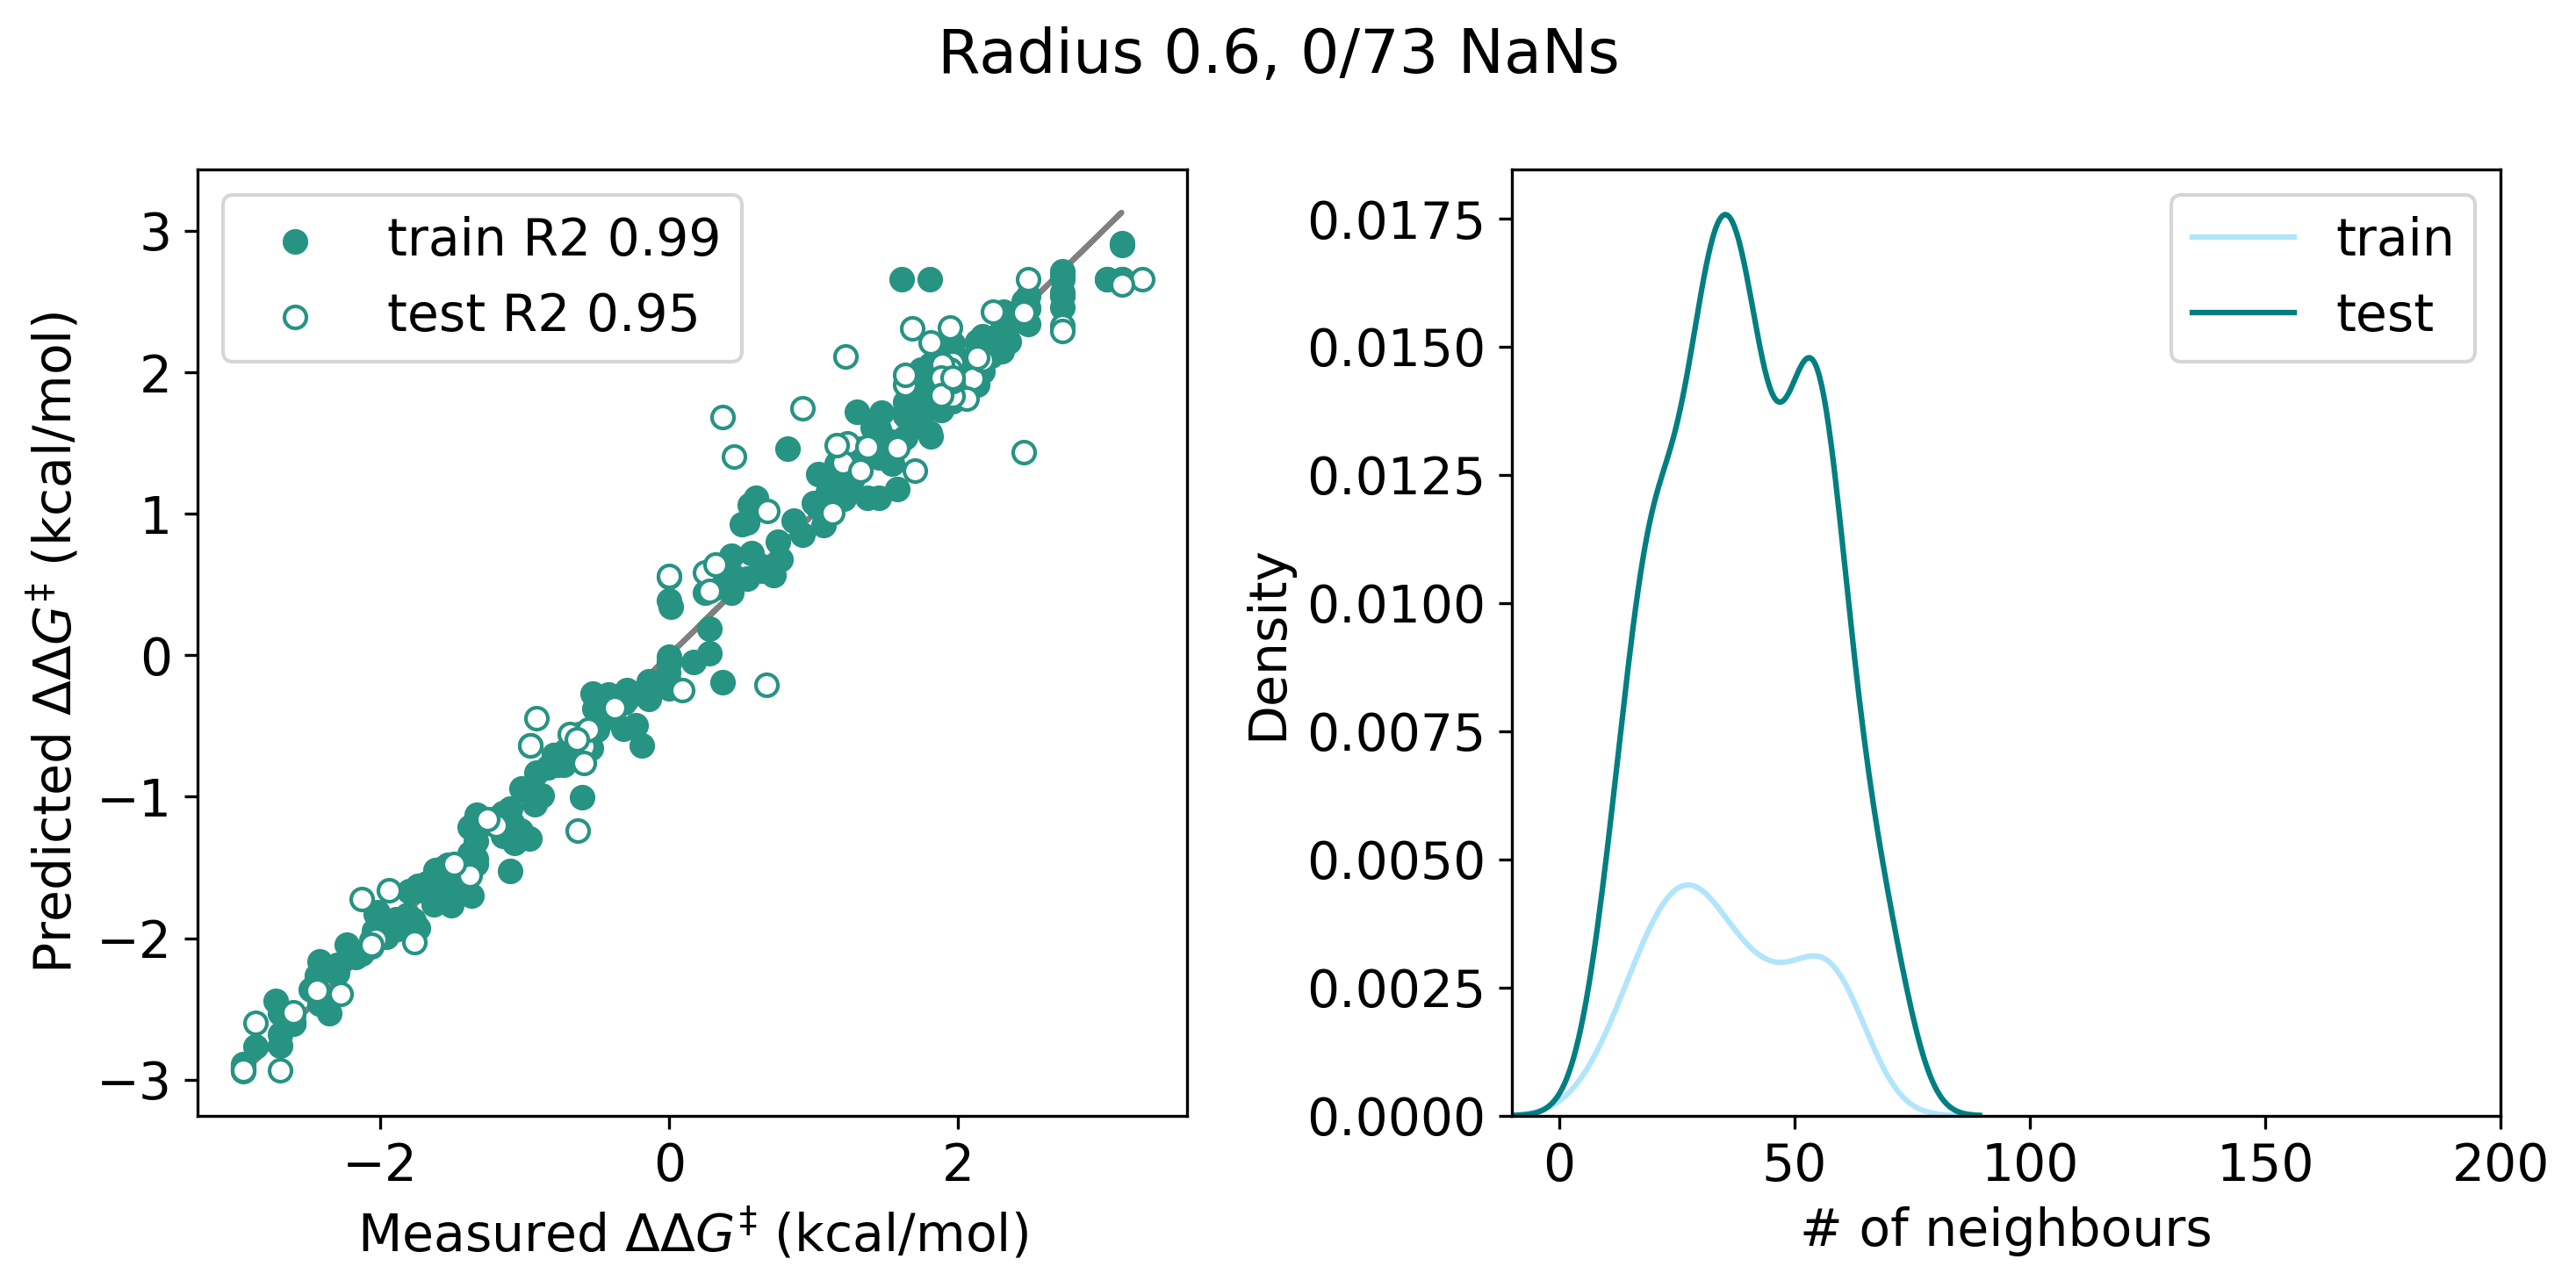

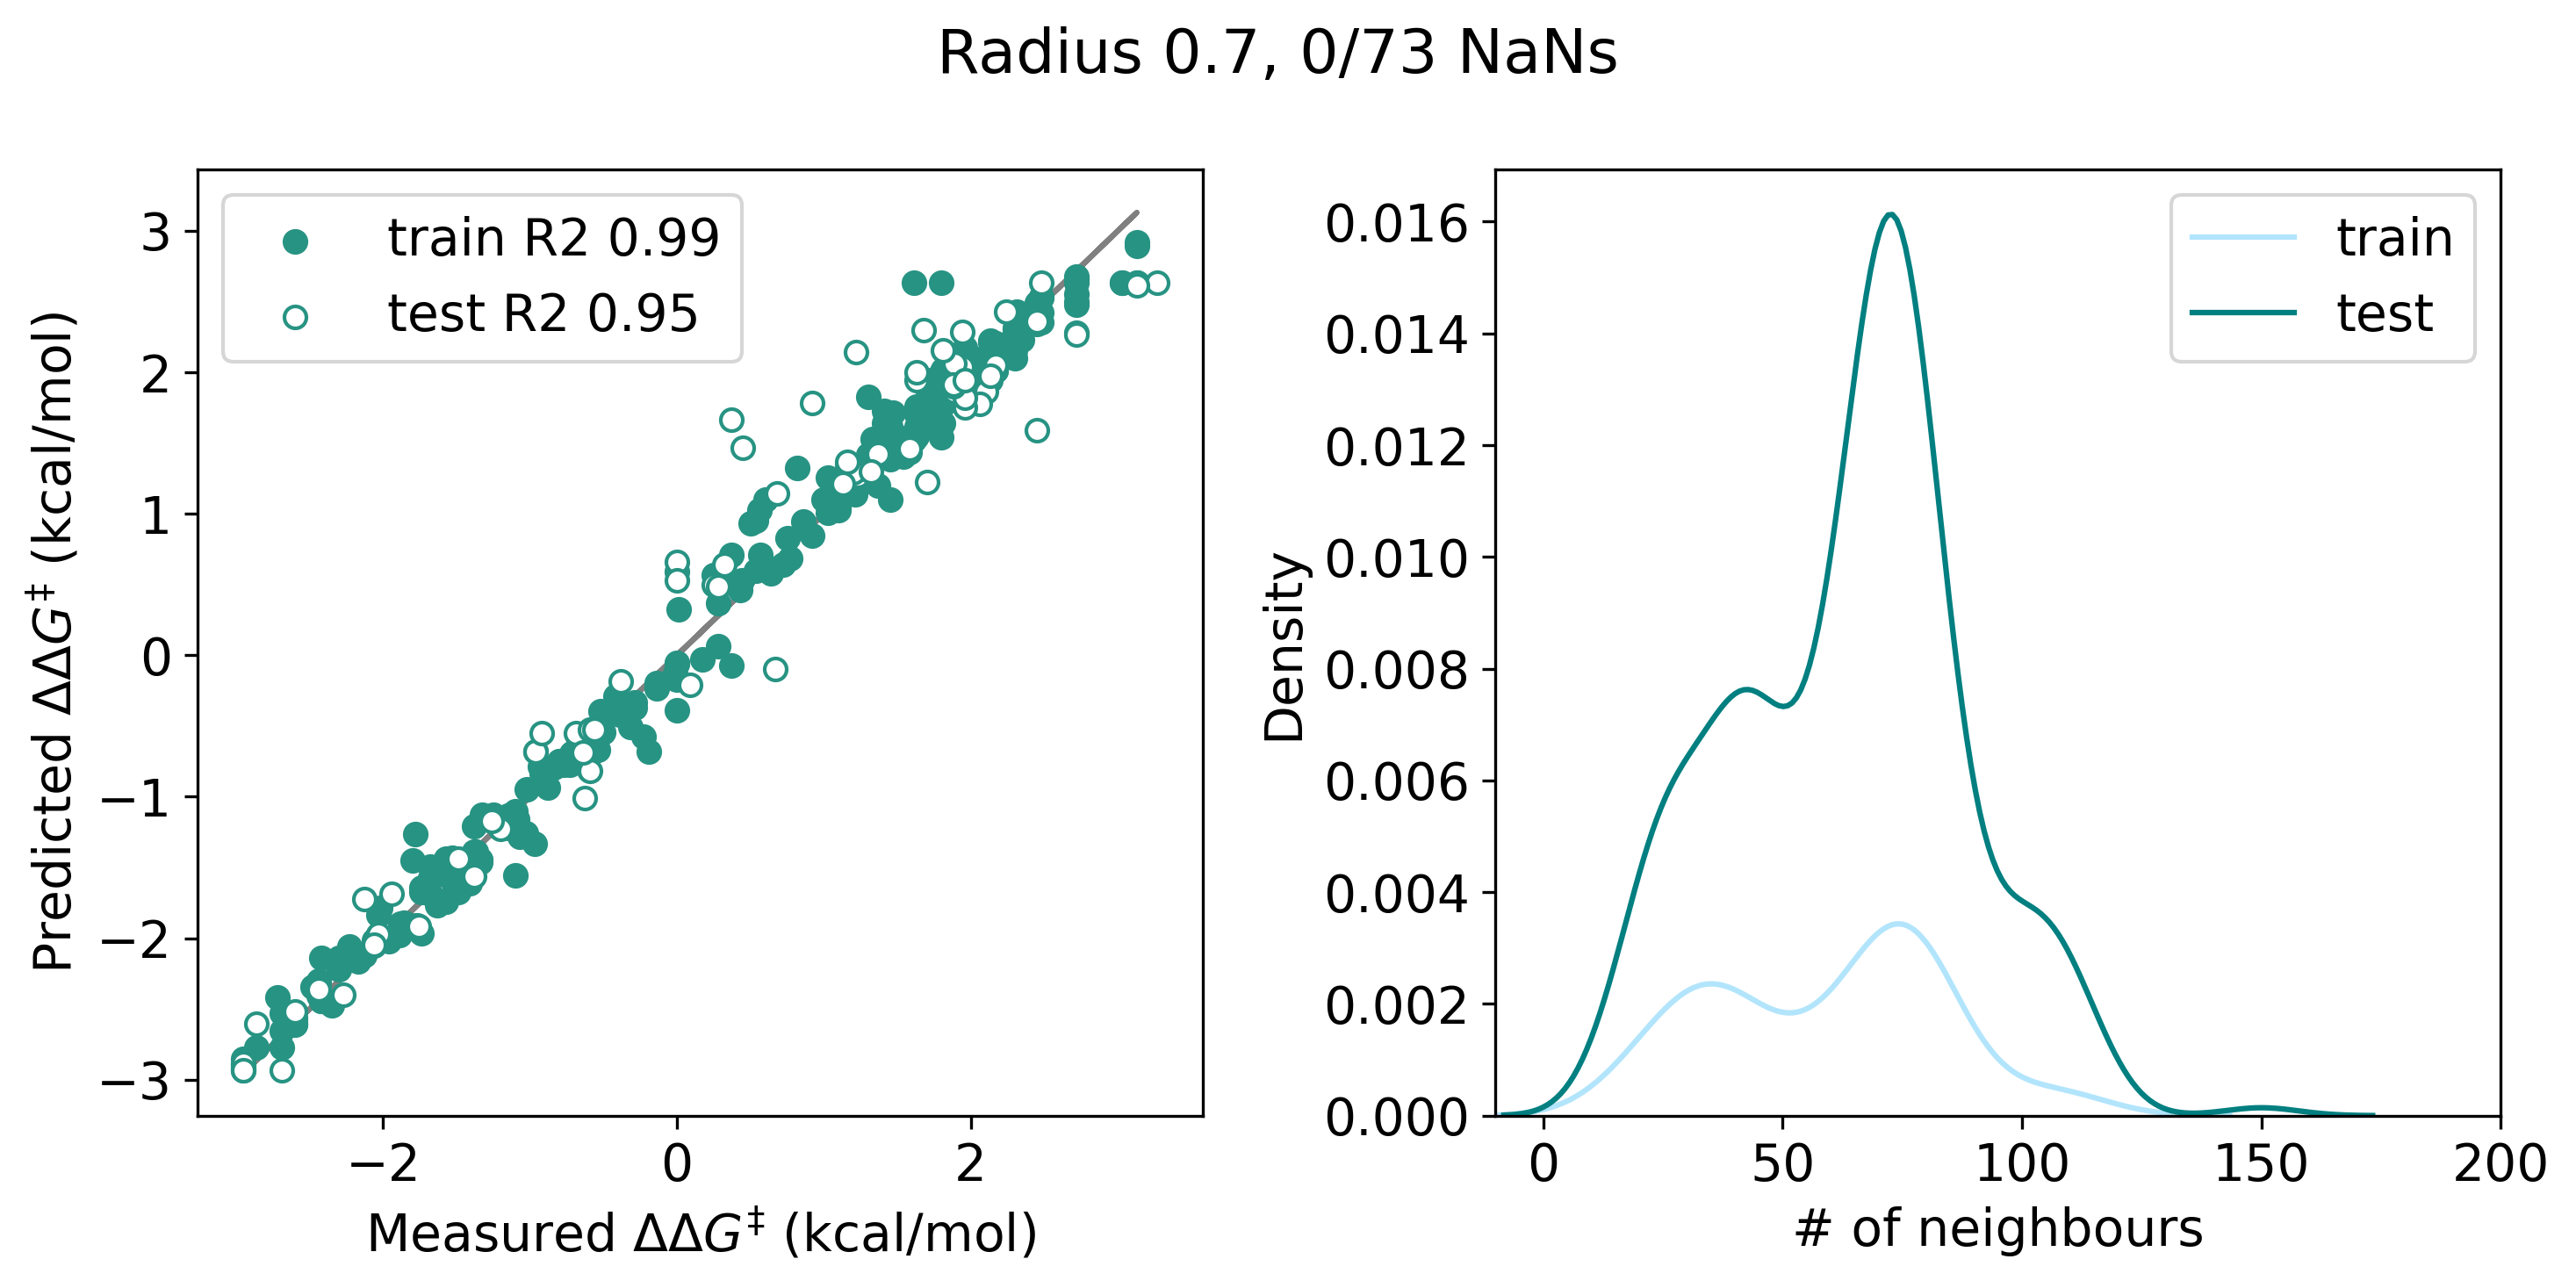

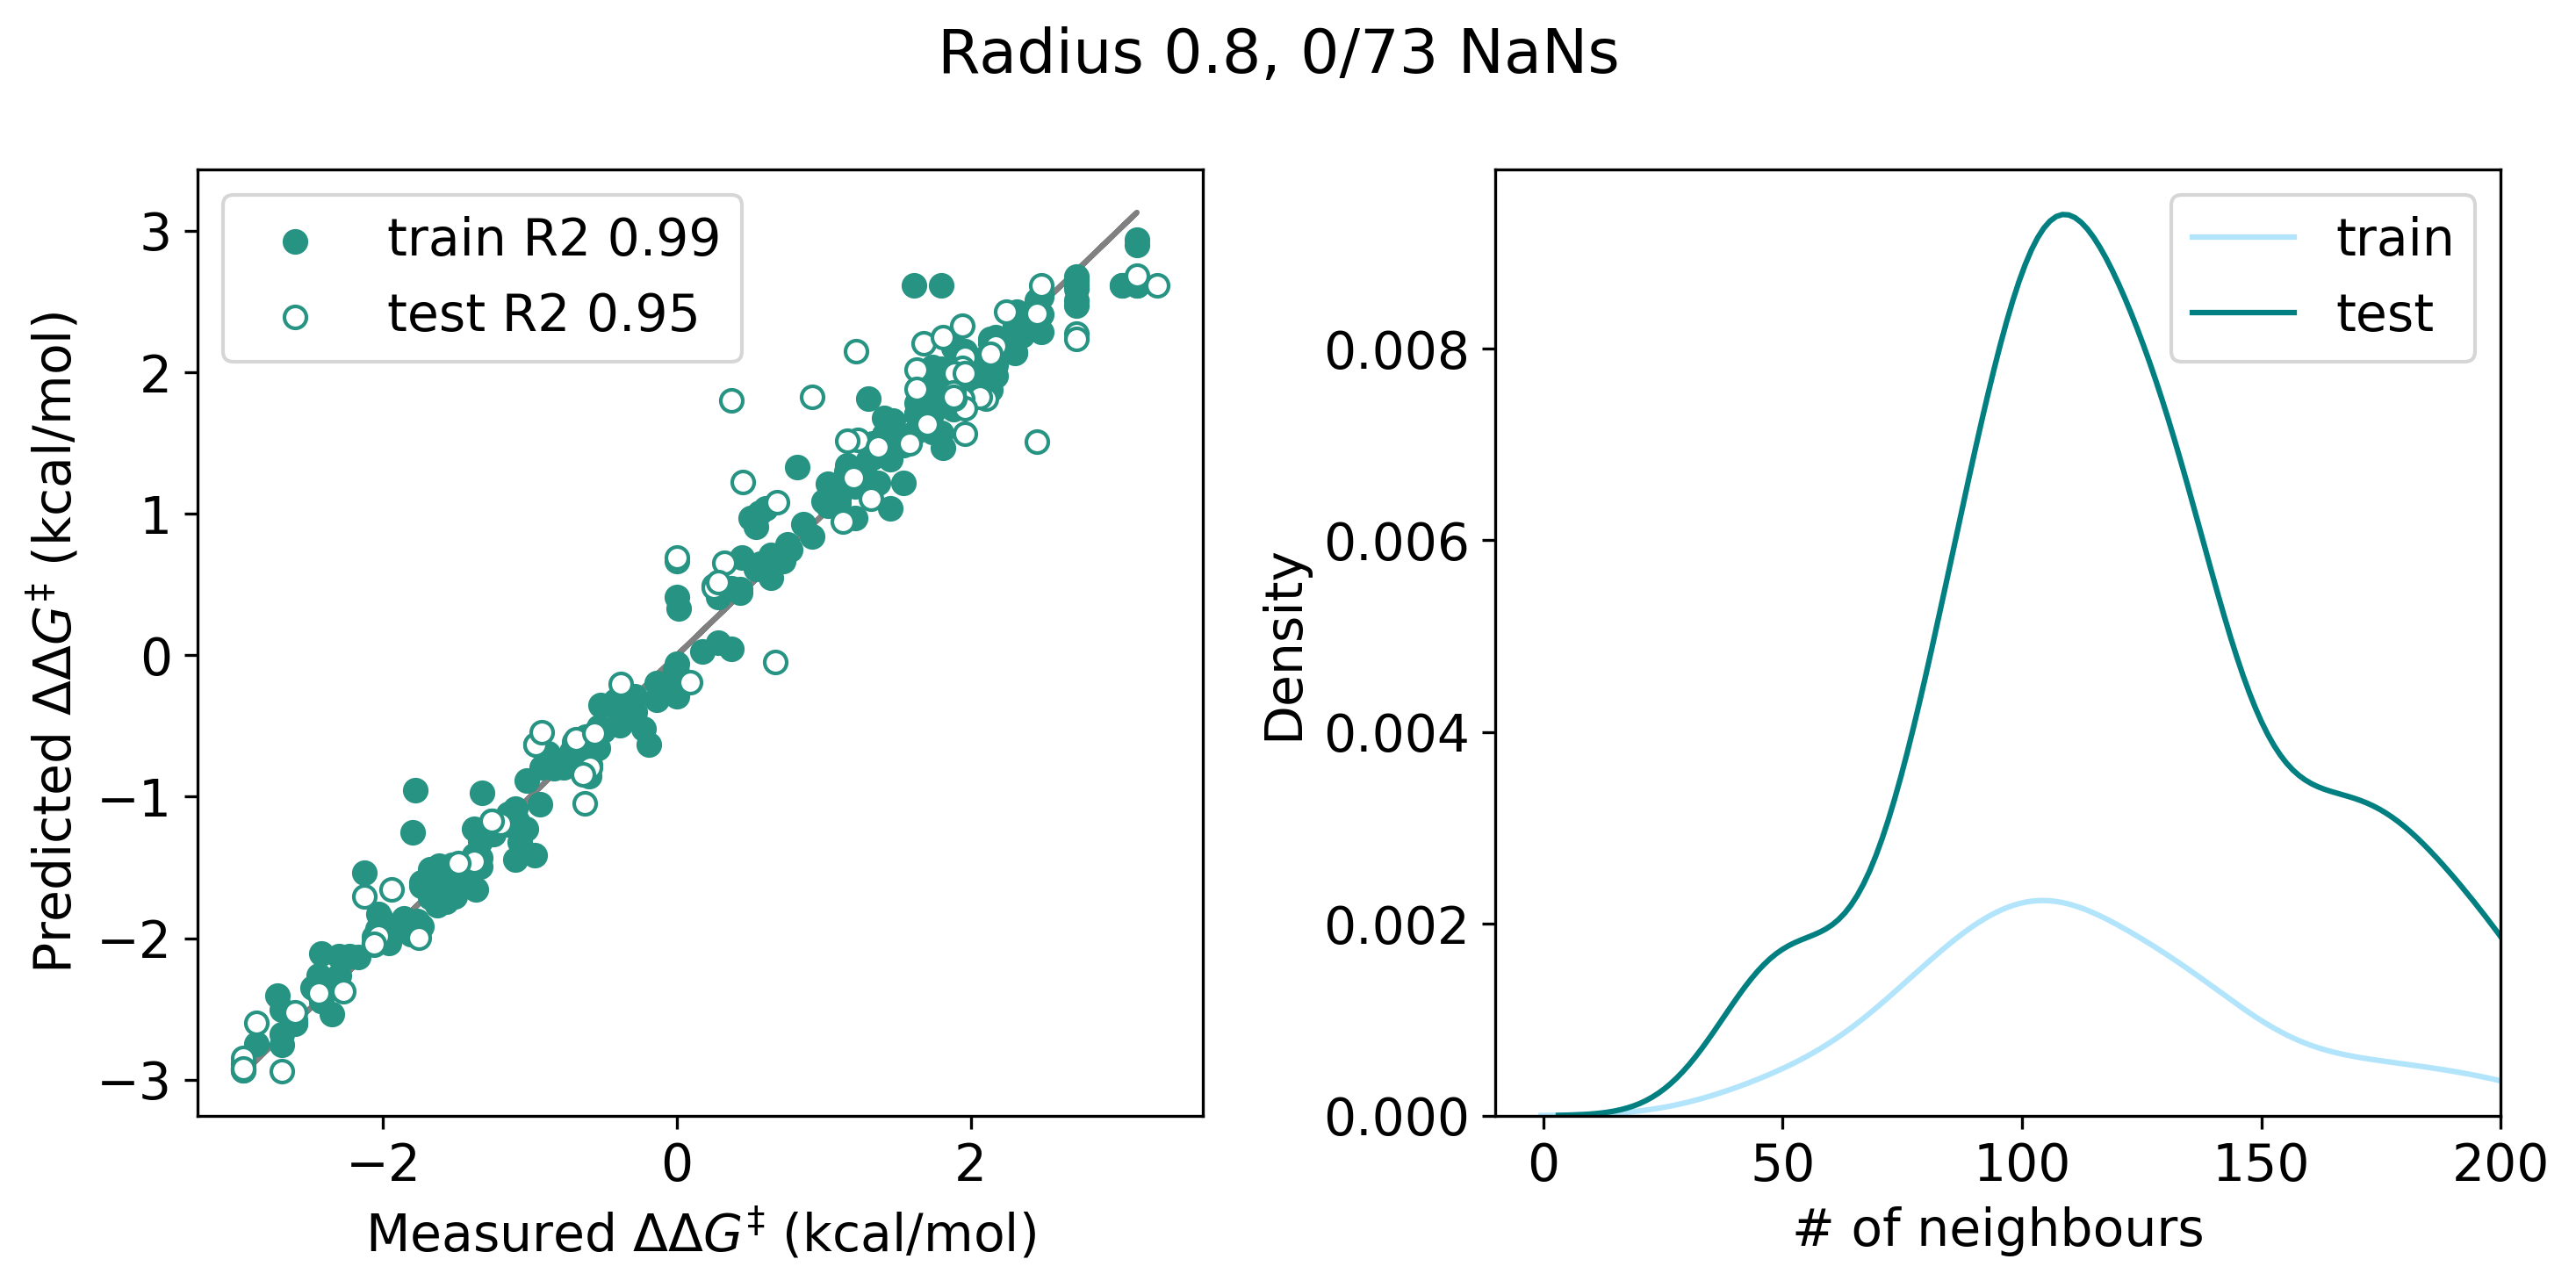

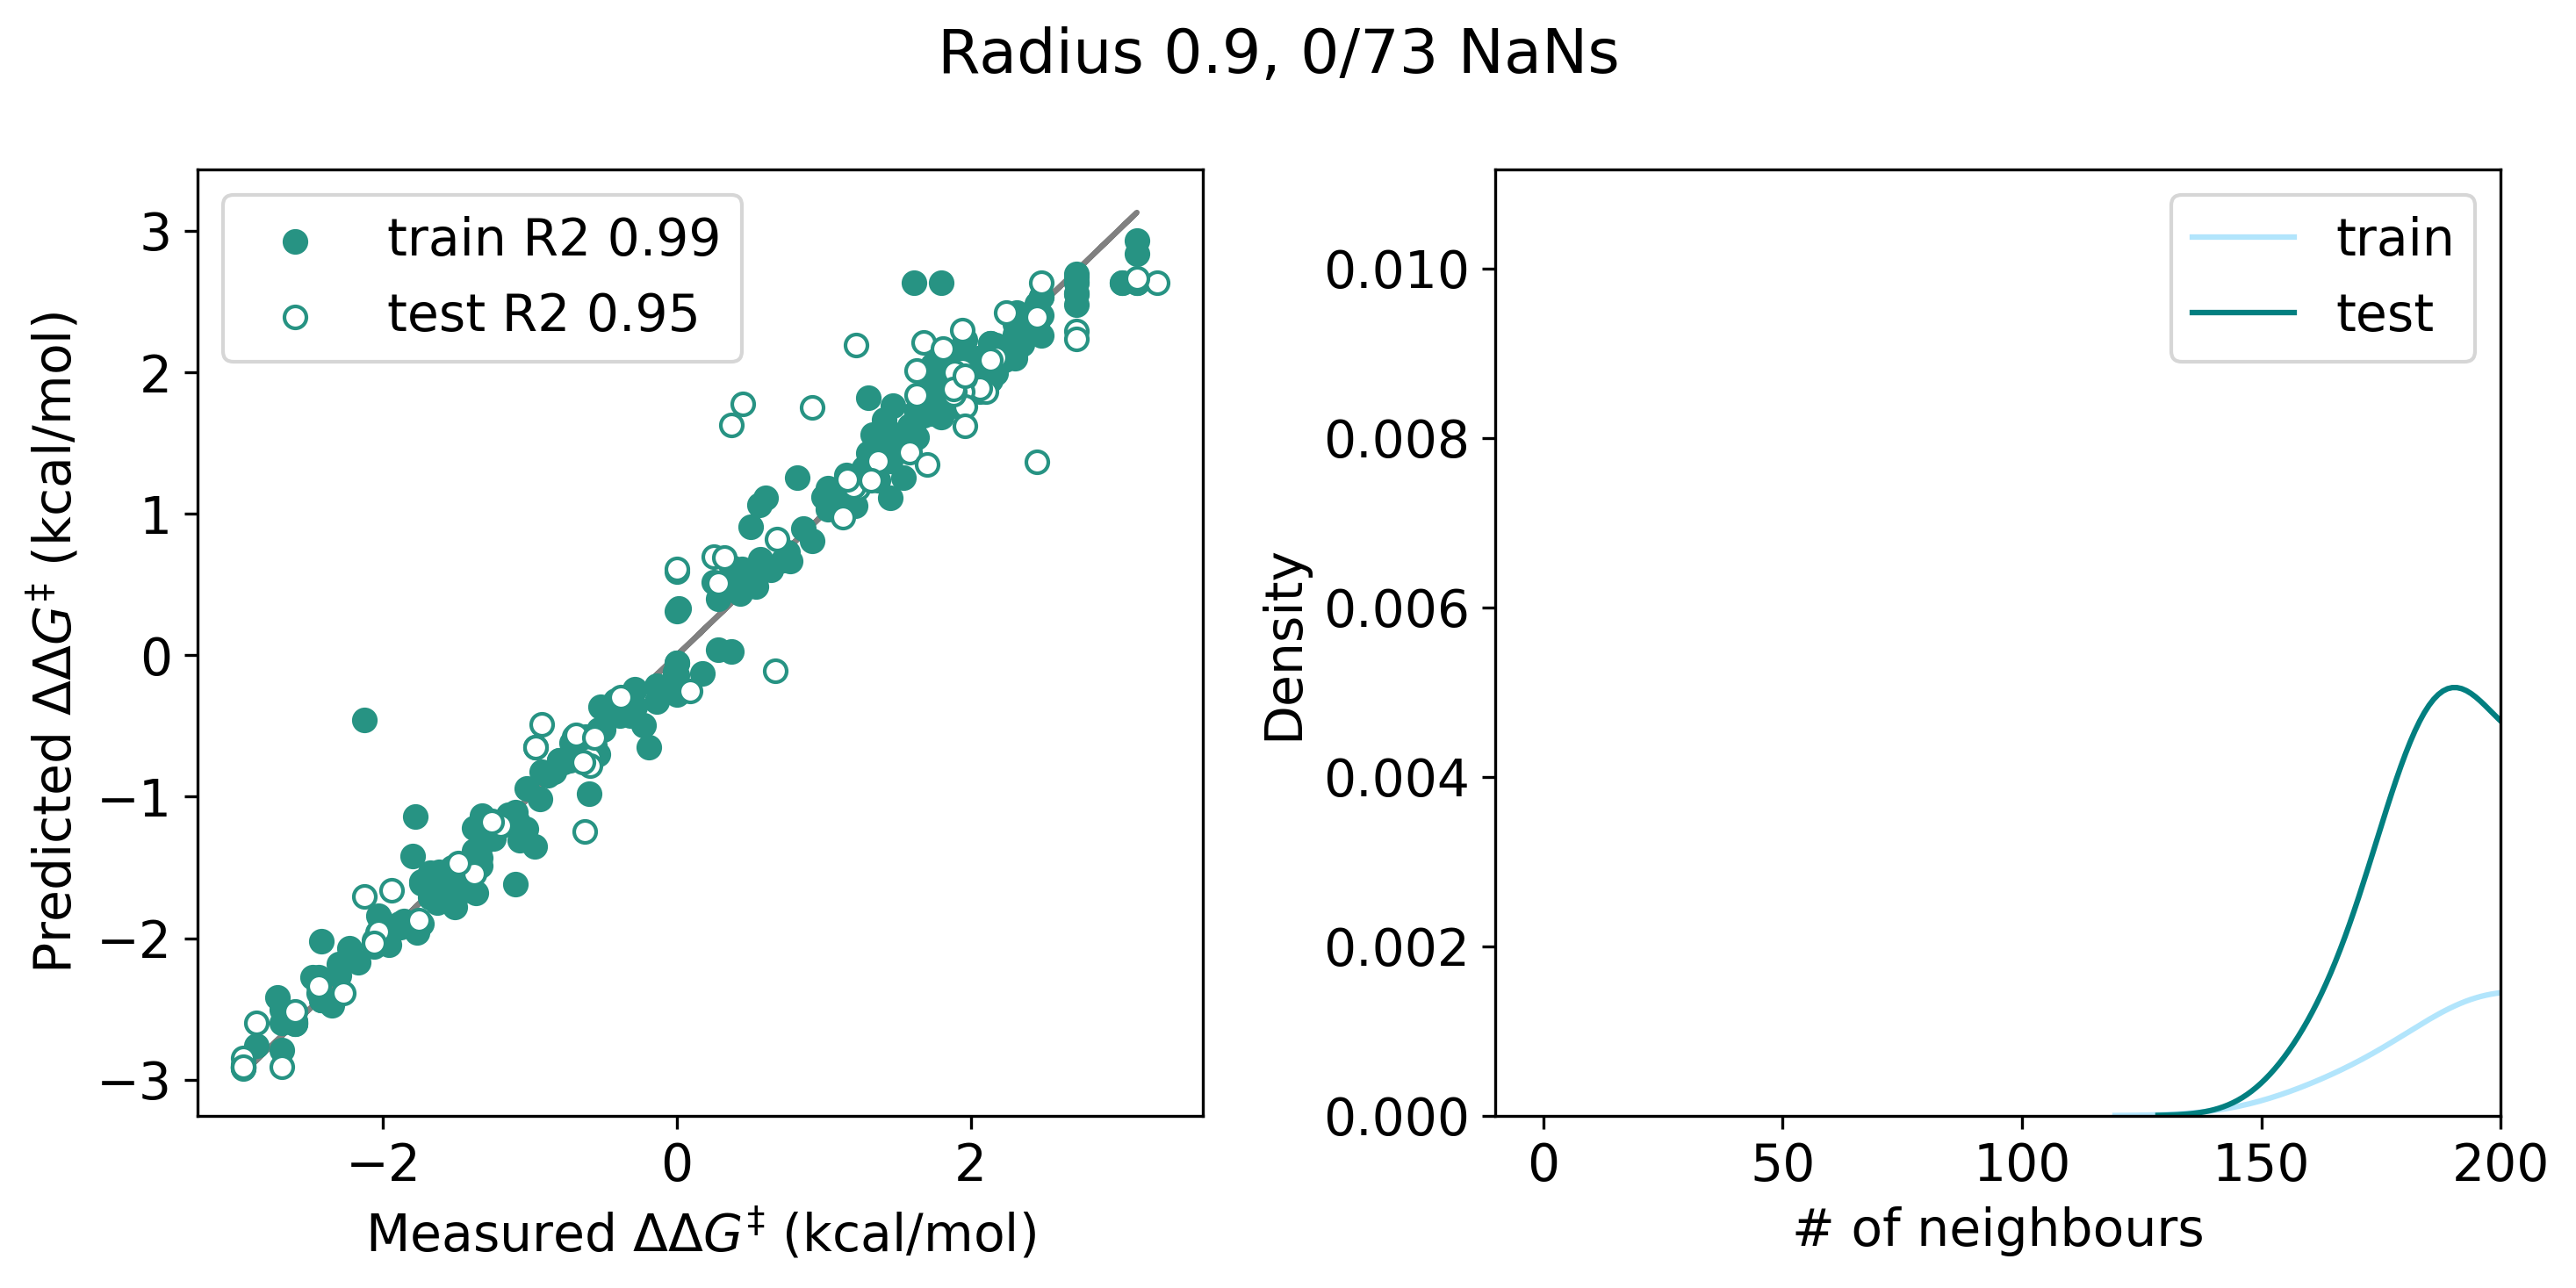

(0.23173106060606144, 0.23584534382284433, 0.2500449059987635, 0.2639002614964947, 0.2632628004377665, 0.26833797496643397, 0.26812416315419774, 0.276582794481014, 0.26998162143032045)
(51, 13, 3, 0, 0, 0, 0, 0, 0)
(2.772727272727273, 5.416666666666667, 9.685714285714285, 15.164383561643836, 21.684931506849313, 36.38356164383562, 59.41095890410959, 114.84931506849315, 233.08219178082192)
({129, 7, 266, 267, 141, 14, 21, 279, 281, 28, 31, 162, 291, 36, 164, 38, 39, 165, 41, 173, 48, 178, 184, 59, 62, 63, 194, 195, 73, 203, 205, 79, 210, 82, 217, 95, 225, 227, 229, 103, 232, 233, 236, 110, 111, 113, 245, 120, 123, 124}, {1, 4, 7, 9, 10, 12, 14, 15, 17, 18, 20, 21, 22, 24, 27, 28, 29, 31, 33, 34, 36, 37, 38, 39, 40, 41, 47, 48, 53, 54, 58, 59, 60, 62, 63, 64, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 82, 85, 87, 89, 90, 92, 93, 95, 97, 99, 101, 102, 103, 104, 105, 107, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 133, 134, 136, 140, 141, 146, 147,

In [4]:
distances = utils.get_distances(X_train,X_test)


# need X_train, y_train, X_test, y_test, distances
results = []

for radius in np.divide(range(1,10),10):
    results.append(run_and_plot(radius, X_train, y_train, X_test, y_test, distances))

RaRF_mae, nans, avg_neighbours, all_reactions, reaction_list, test_r2s = zip(*results)

print(RaRF_mae)
print(nans)
print(avg_neighbours)
print(all_reactions)
print([len(ar) for ar in all_reactions])
print(reaction_list)
print(test_r2s)

In [5]:
# Wait. Why are those the same? Are they all the same reactions? They must be, right?
# Probably, Double check. Then, save some work.
# They are.
# Then, just do aquisitions.
# But the R2's are a little different. And so are the MAEs. I hope it's not some shenanigs.
# Okay, I need to set an sklearn seed.
# Look at random state. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
RaRF_mae

(0.23173106060606144,
 0.23584534382284433,
 0.2500449059987635,
 0.2639002614964947,
 0.2632628004377665,
 0.26833797496643397,
 0.26812416315419774,
 0.276582794481014,
 0.26998162143032045)

In [6]:
num_reactions = [len(ar) for ar in all_reactions]

In [7]:
# Reactions used starting from the 5th (0.6) radius onward are the same.
[all_reactions[i] == all_reactions[i + 1] for i in range(4, 8)]

[False, True, True, True]

In [8]:
def get_sorted_neighbours(cutoff):
    neighbour_matrix = distances <= cutoff
    
    num_test = distances.shape[0]
    
    
    cutoff = cutoffs[i]
    
    
    mask = distances <= cutoff
    
    # the ith element is a list of all neighbours for the ith test example.
    test_neighbours = [np.where(row)[0].tolist() for row in mask]
    
    # the ith element is a list of all neighbours for the ith train example.
    train_neighbours = [np.where(row)[0].tolist() for row in mask.T]
    
    # a list of training examples we've chosen.
    chosen_train = []
    
    
    
    # number of neighbours already selected for each test example
    num_selected_neighbours = np.array([0] * num_test)
    
    
    # set of test examples that have no more unselected neighbours
    fully_chosen_tests = set([i for i, neighs in enumerate(test_neighbours) if len(neighs) == 0])
    
    while (len(fully_chosen_tests) < num_test):
        
        live_tests = np.array([i for i in range(num_test) if i not in fully_chosen_tests])
    
        # of the test examples that still have unselected neighbours, what is the fewest number of selected neighbours
        fewest_neighs = np.min(num_selected_neighbours[live_tests])
    
        # test examples that have the fewest selected neighbours that still have neighbours to select
        neediest_tests = np.array([t for t in np.where(num_selected_neighbours == fewest_neighs)[0] if t in live_tests])
        cur_mask = mask[neediest_tests]
        
        train_neighbours = [(i, np.where(row)[0].tolist()) for i, row in enumerate(cur_mask.T)]
        train_neighbours = sorted(train_neighbours, key=lambda example: len(example[1]), reverse=True)
        
        
        # the train example we are adding
        selected = train_neighbours[0][0]
        
        # test_examples that got a new neighbour
        new_neighbours = neediest_tests[train_neighbours[0][1]]
        
        chosen_train.append(selected)
        
        # remove the selected reaction from the list of neighbours that have it.
        for neigh in new_neighbours:
            test_neighbours[neigh].remove(selected)
            num_selected_neighbours[neigh] += 1
        
        fully_chosen_tests = set([i for i, neighs in enumerate(test_neighbours) if len(neighs) == 0])
    
        mask[:,selected] = False

    
    
    return chosen_train

In [9]:
cutoffs = np.divide(range(1, 7), 10)

cutoffs

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [10]:
RaRF_mae

(0.23173106060606144,
 0.23584534382284433,
 0.2500449059987635,
 0.2639002614964947,
 0.2632628004377665,
 0.26833797496643397,
 0.26812416315419774,
 0.276582794481014,
 0.26998162143032045)

In [11]:
def run_MT(cutoff, max_budget, ref_mae, ref_r2):
    results = []
    
    
    sorted_neigh = get_sorted_neighbours(cutoff)
    
    multipliers = np.divide(range(1, 11), 10)
    
    for multiplier in multipliers:
        budget = int(max_budget * multiplier)
        print(budget)
        cur_indicies = sorted_neigh[0:budget]
    
        cur_distances = np.full_like(distances, 2)
    
        cur_distances[:,cur_indicies] = distances[:,cur_indicies]
    
        results.append(run_and_plot(cutoff, X_train, y_train, X_test, y_test, cur_distances,  
                                    title_extra = ", Budget: {}, Percent Used: {:.1f}%".format(budget, multiplier * 100)))


    
    cur_RaRF_mae, cur_nans, cur_avg_neighbours, cur_all_reactions, cur_reaction_list, cur_test_r2s = zip(*results)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=300)

    title = "MAE to Percent of Reactions Used \n(Radius = {})".format(cutoff)

    ref_num_points = 1000

    ref_x = np.array(range(0, ref_num_points)) * 100 / ref_num_points

    ax1.set_title(title)
    ax1.set_ylabel("MAE")
    ax1.set_xlabel("% of Reactions Used")
    ax1.scatter(ref_x, [ref_mae] * ref_num_points, label = "Reference", s=0.5)
    ax1.scatter(100 * multipliers, cur_RaRF_mae, label="Actual")
    ax1.legend()

    ax2.set_title("MAE to Percent of Reactions Used \n(Radius = 0.1)")
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    ax2.set_ylabel("R^2",rotation=270)
    ax2.set_xlabel("% of Reactions Used")
    ax2.scatter(ref_x, [ref_r2] * ref_num_points, label = "Reference", s=0.5)
    ax2.scatter(100 * multipliers, cur_test_r2s, label="Actual")

    ax2.legend()


    plt.show()


    print(test_r2s)

5


/tmp/ipykernel_19366/766924046.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


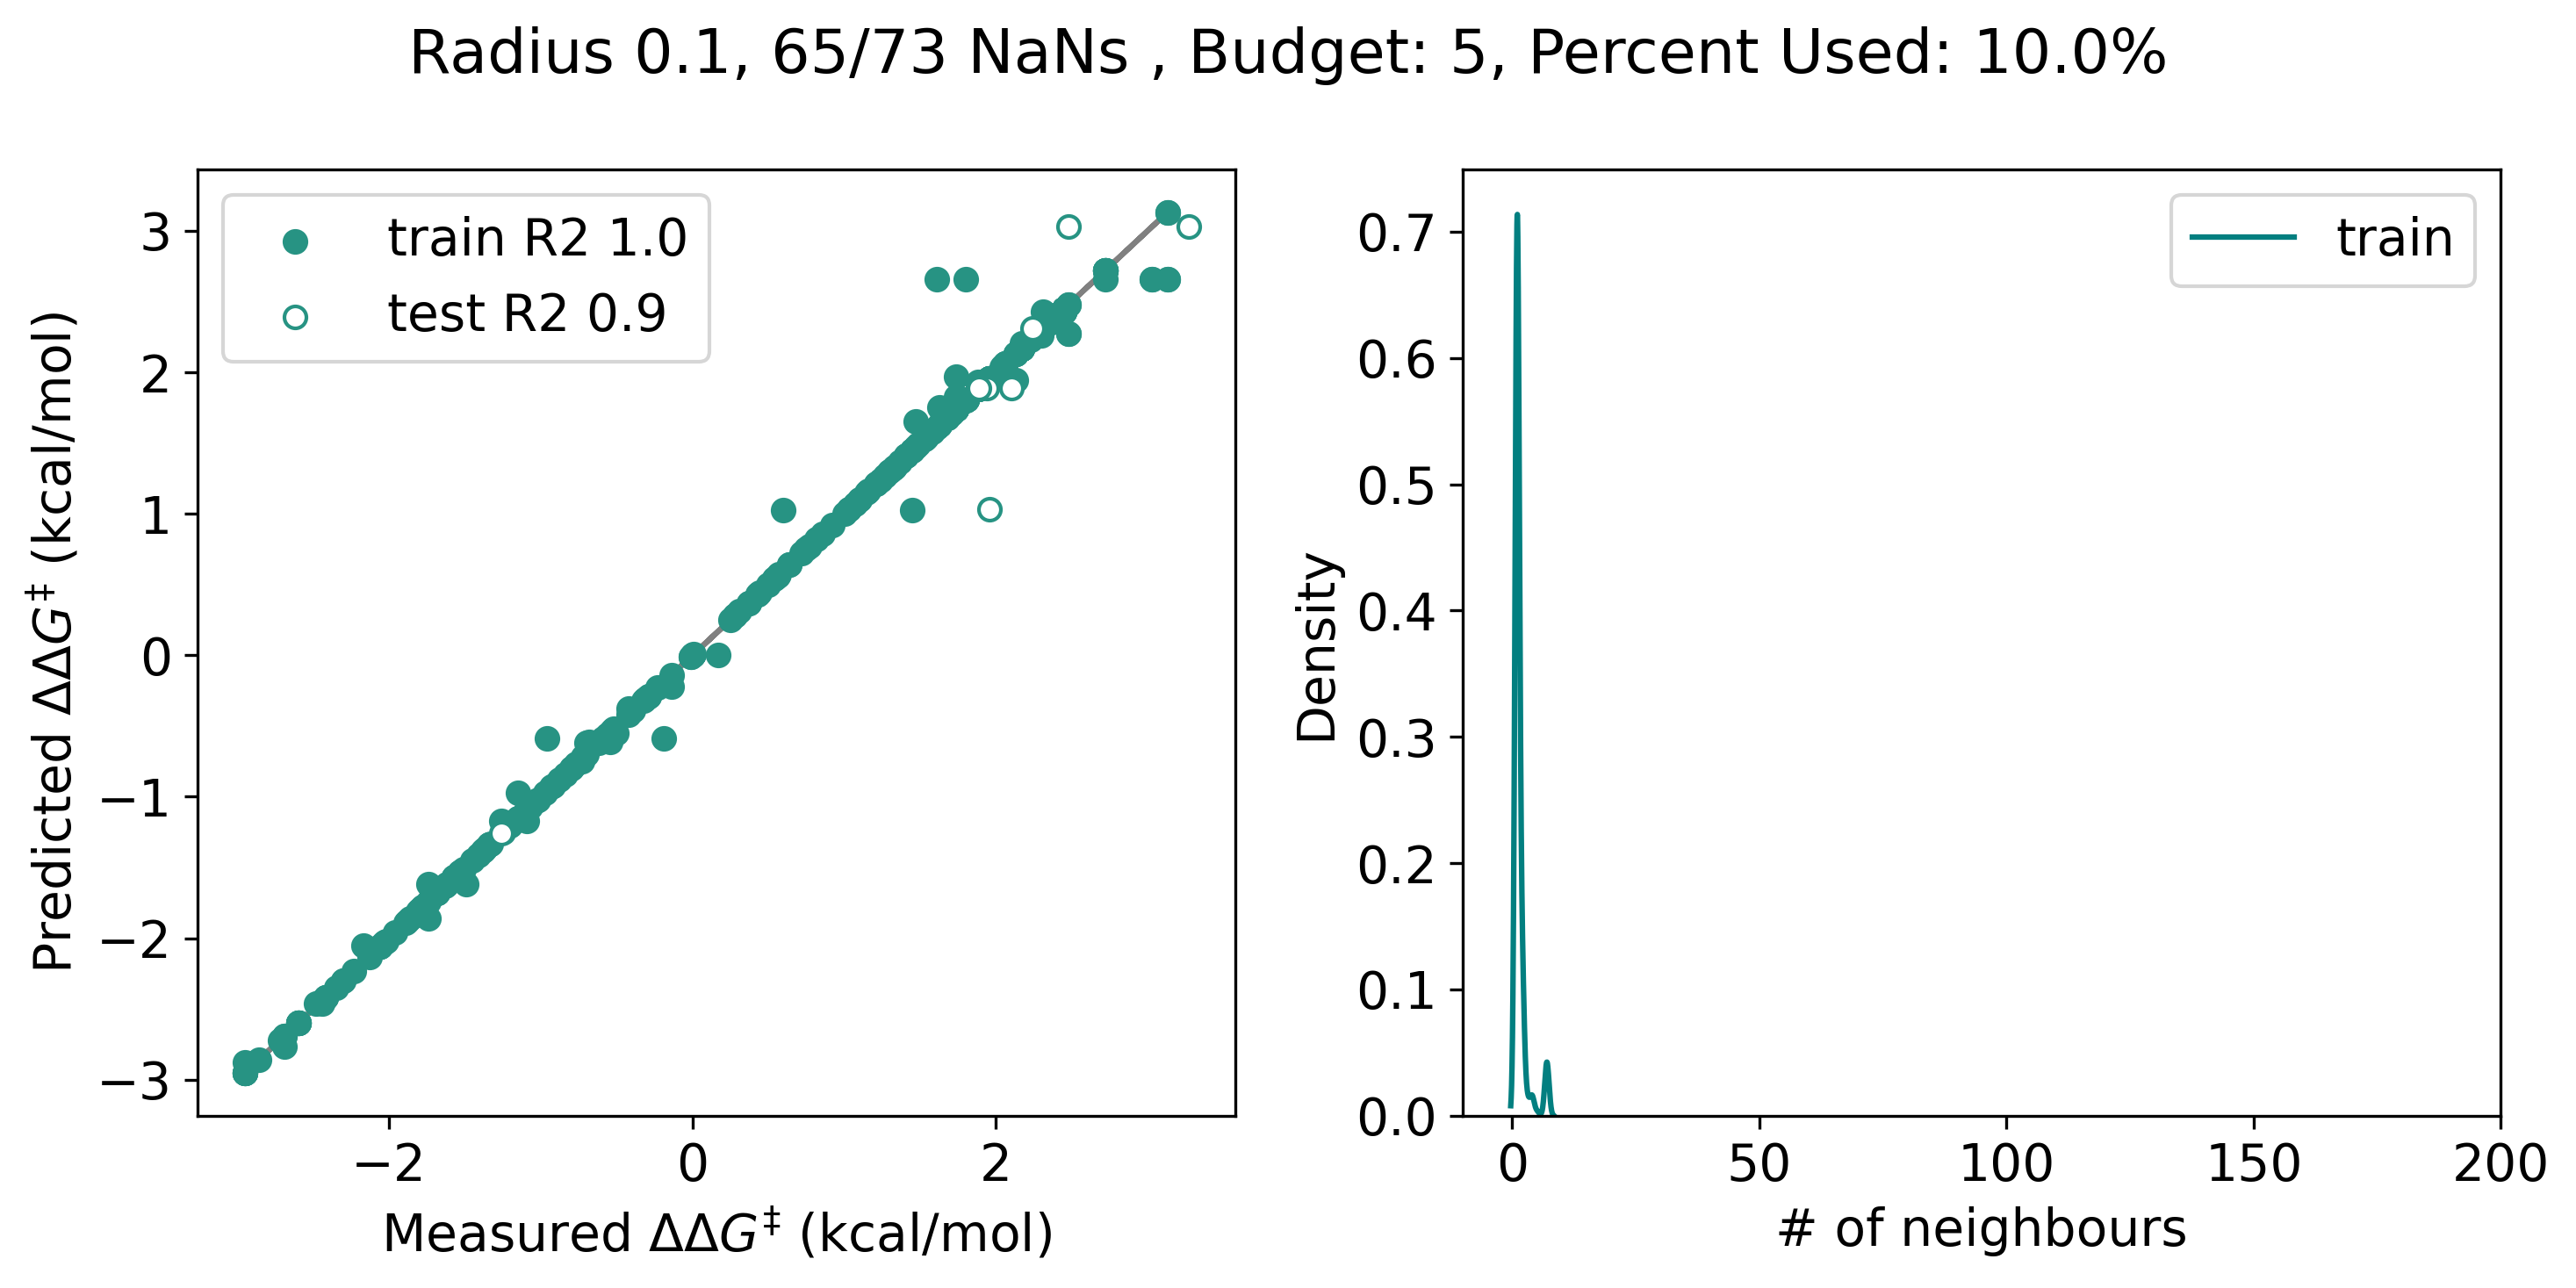

10


/tmp/ipykernel_19366/766924046.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


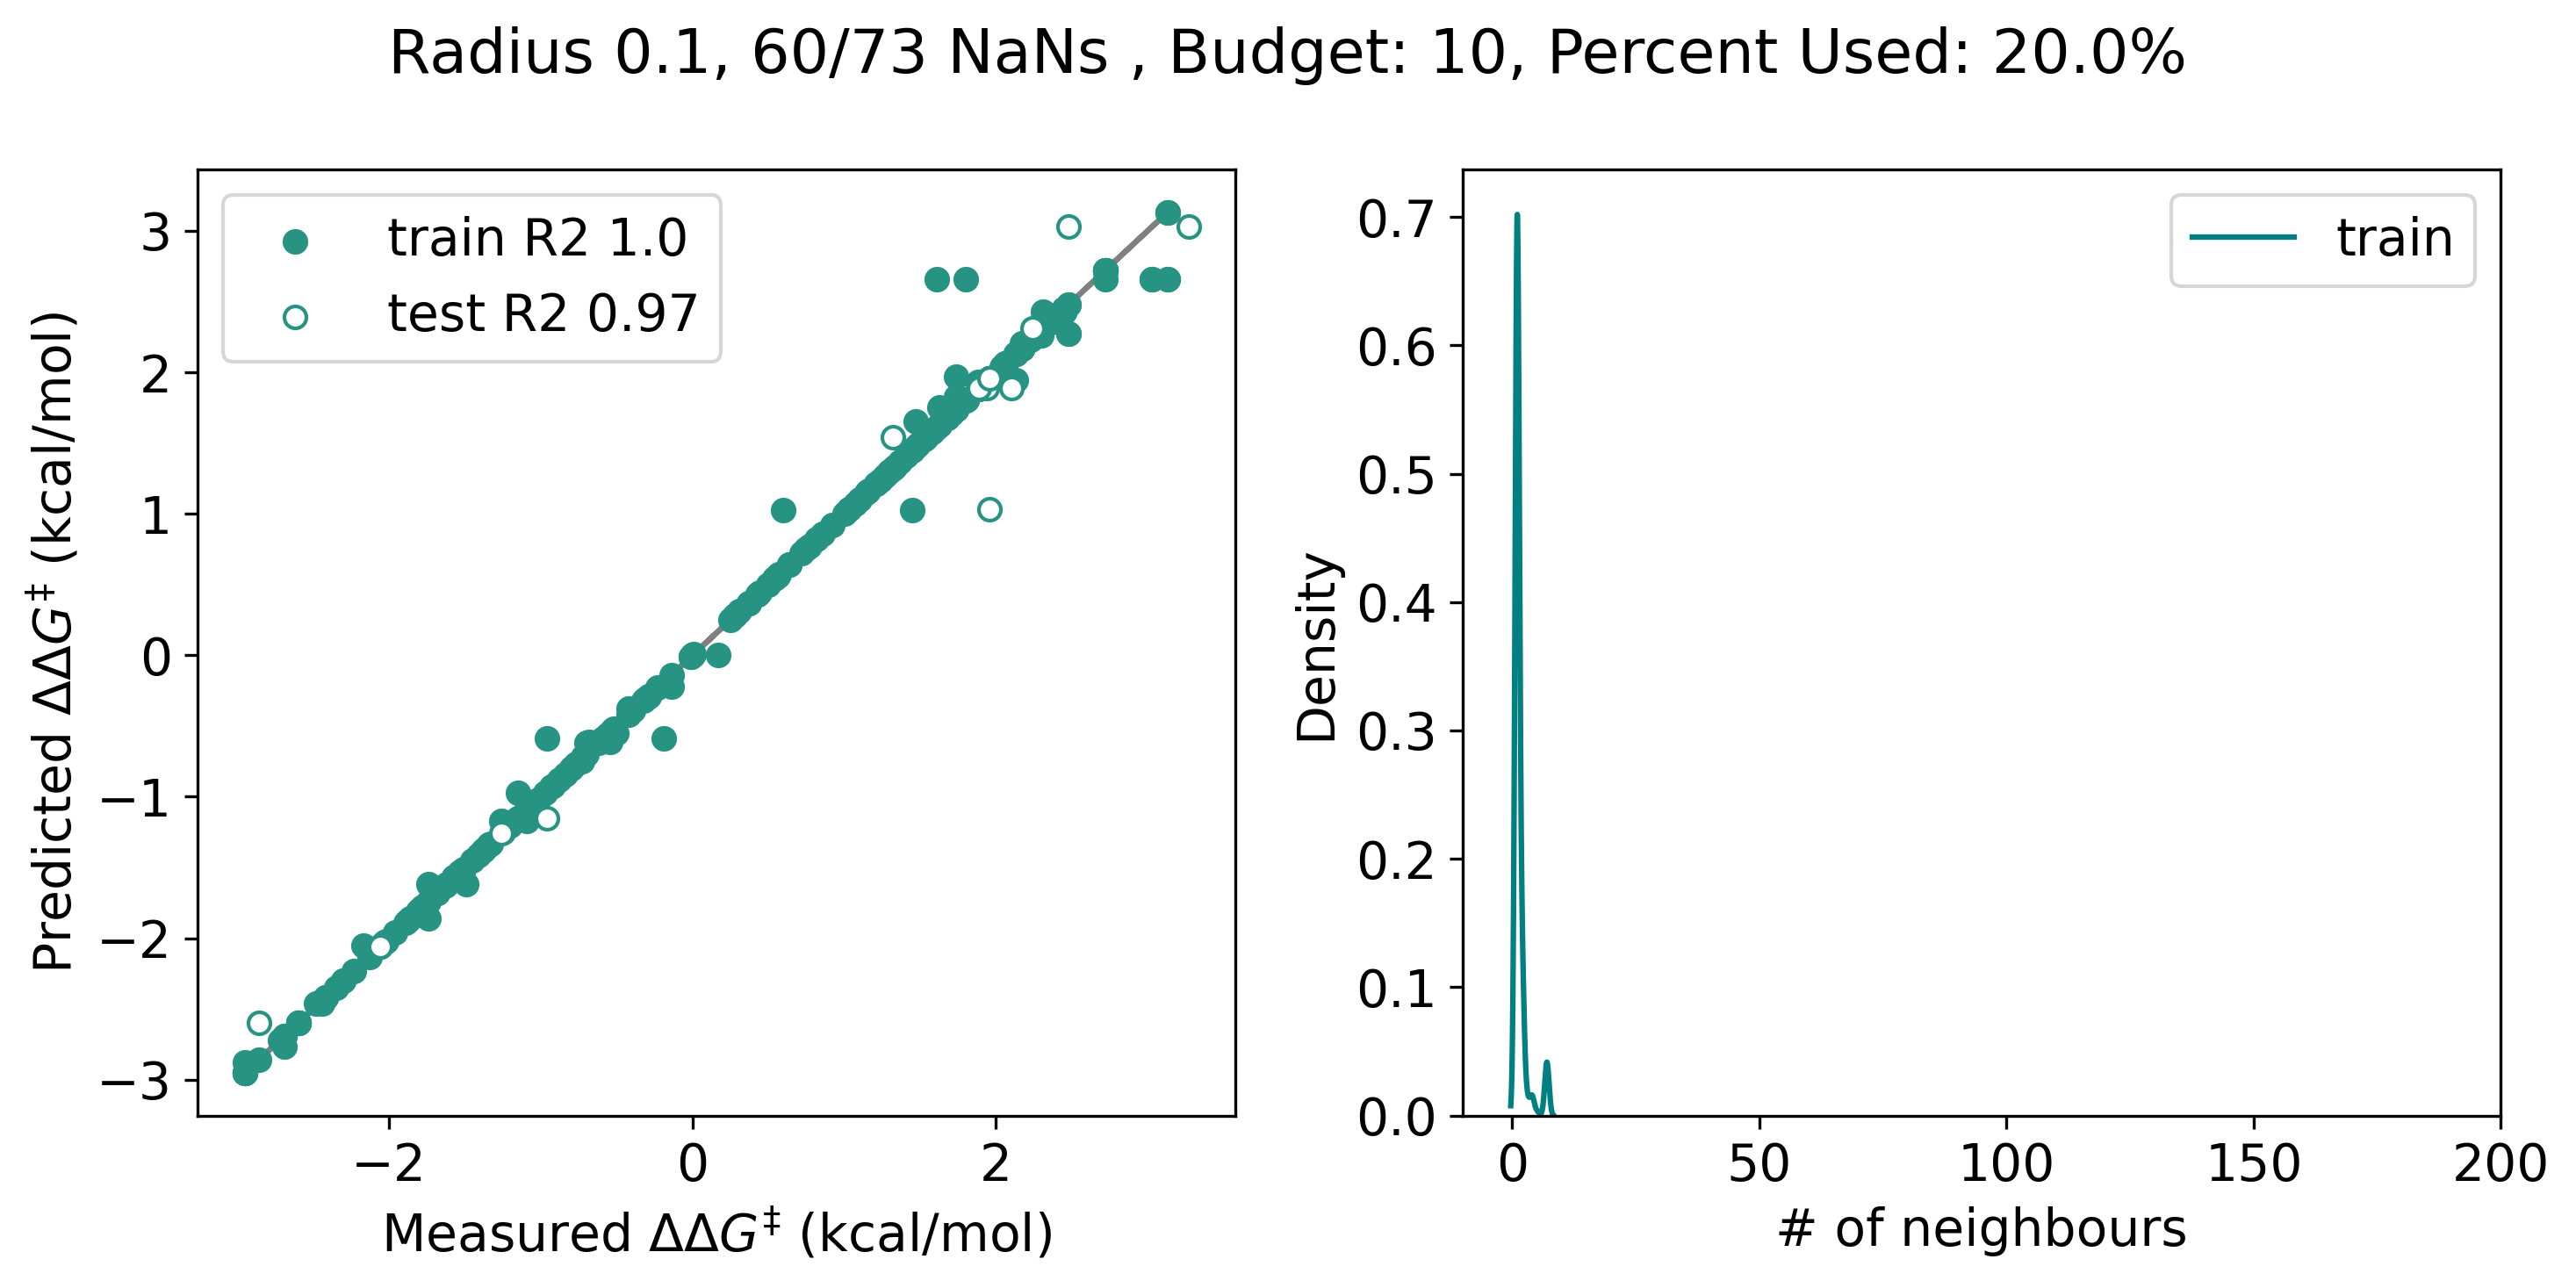

15


/tmp/ipykernel_19366/766924046.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


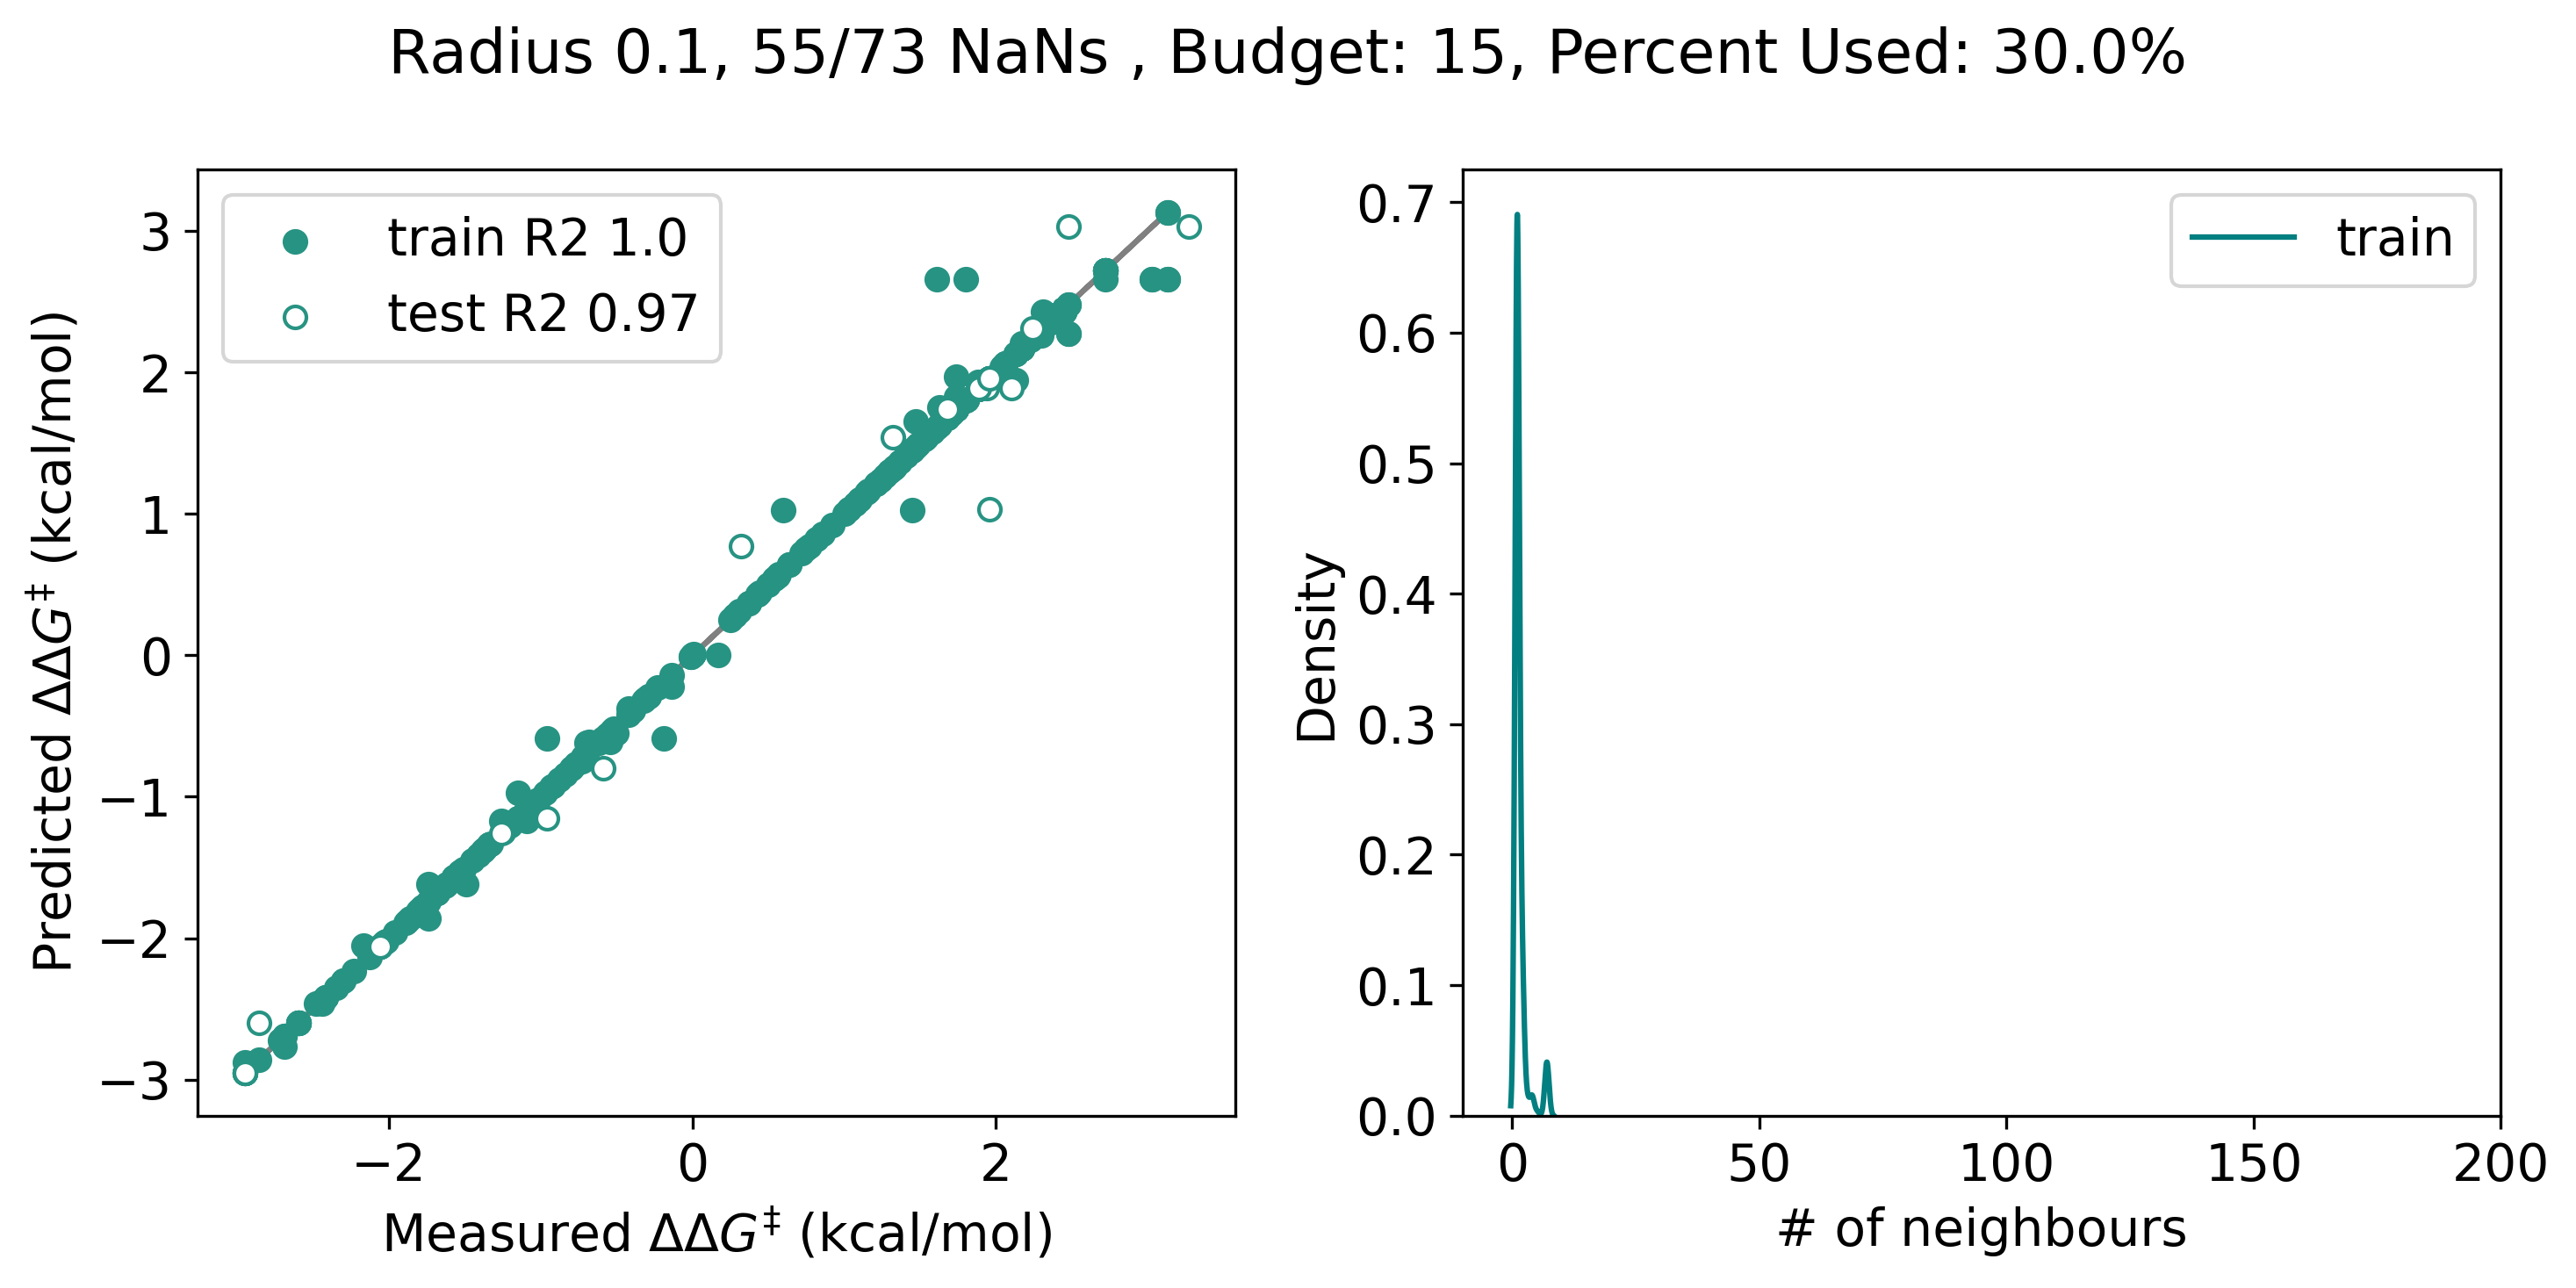

20


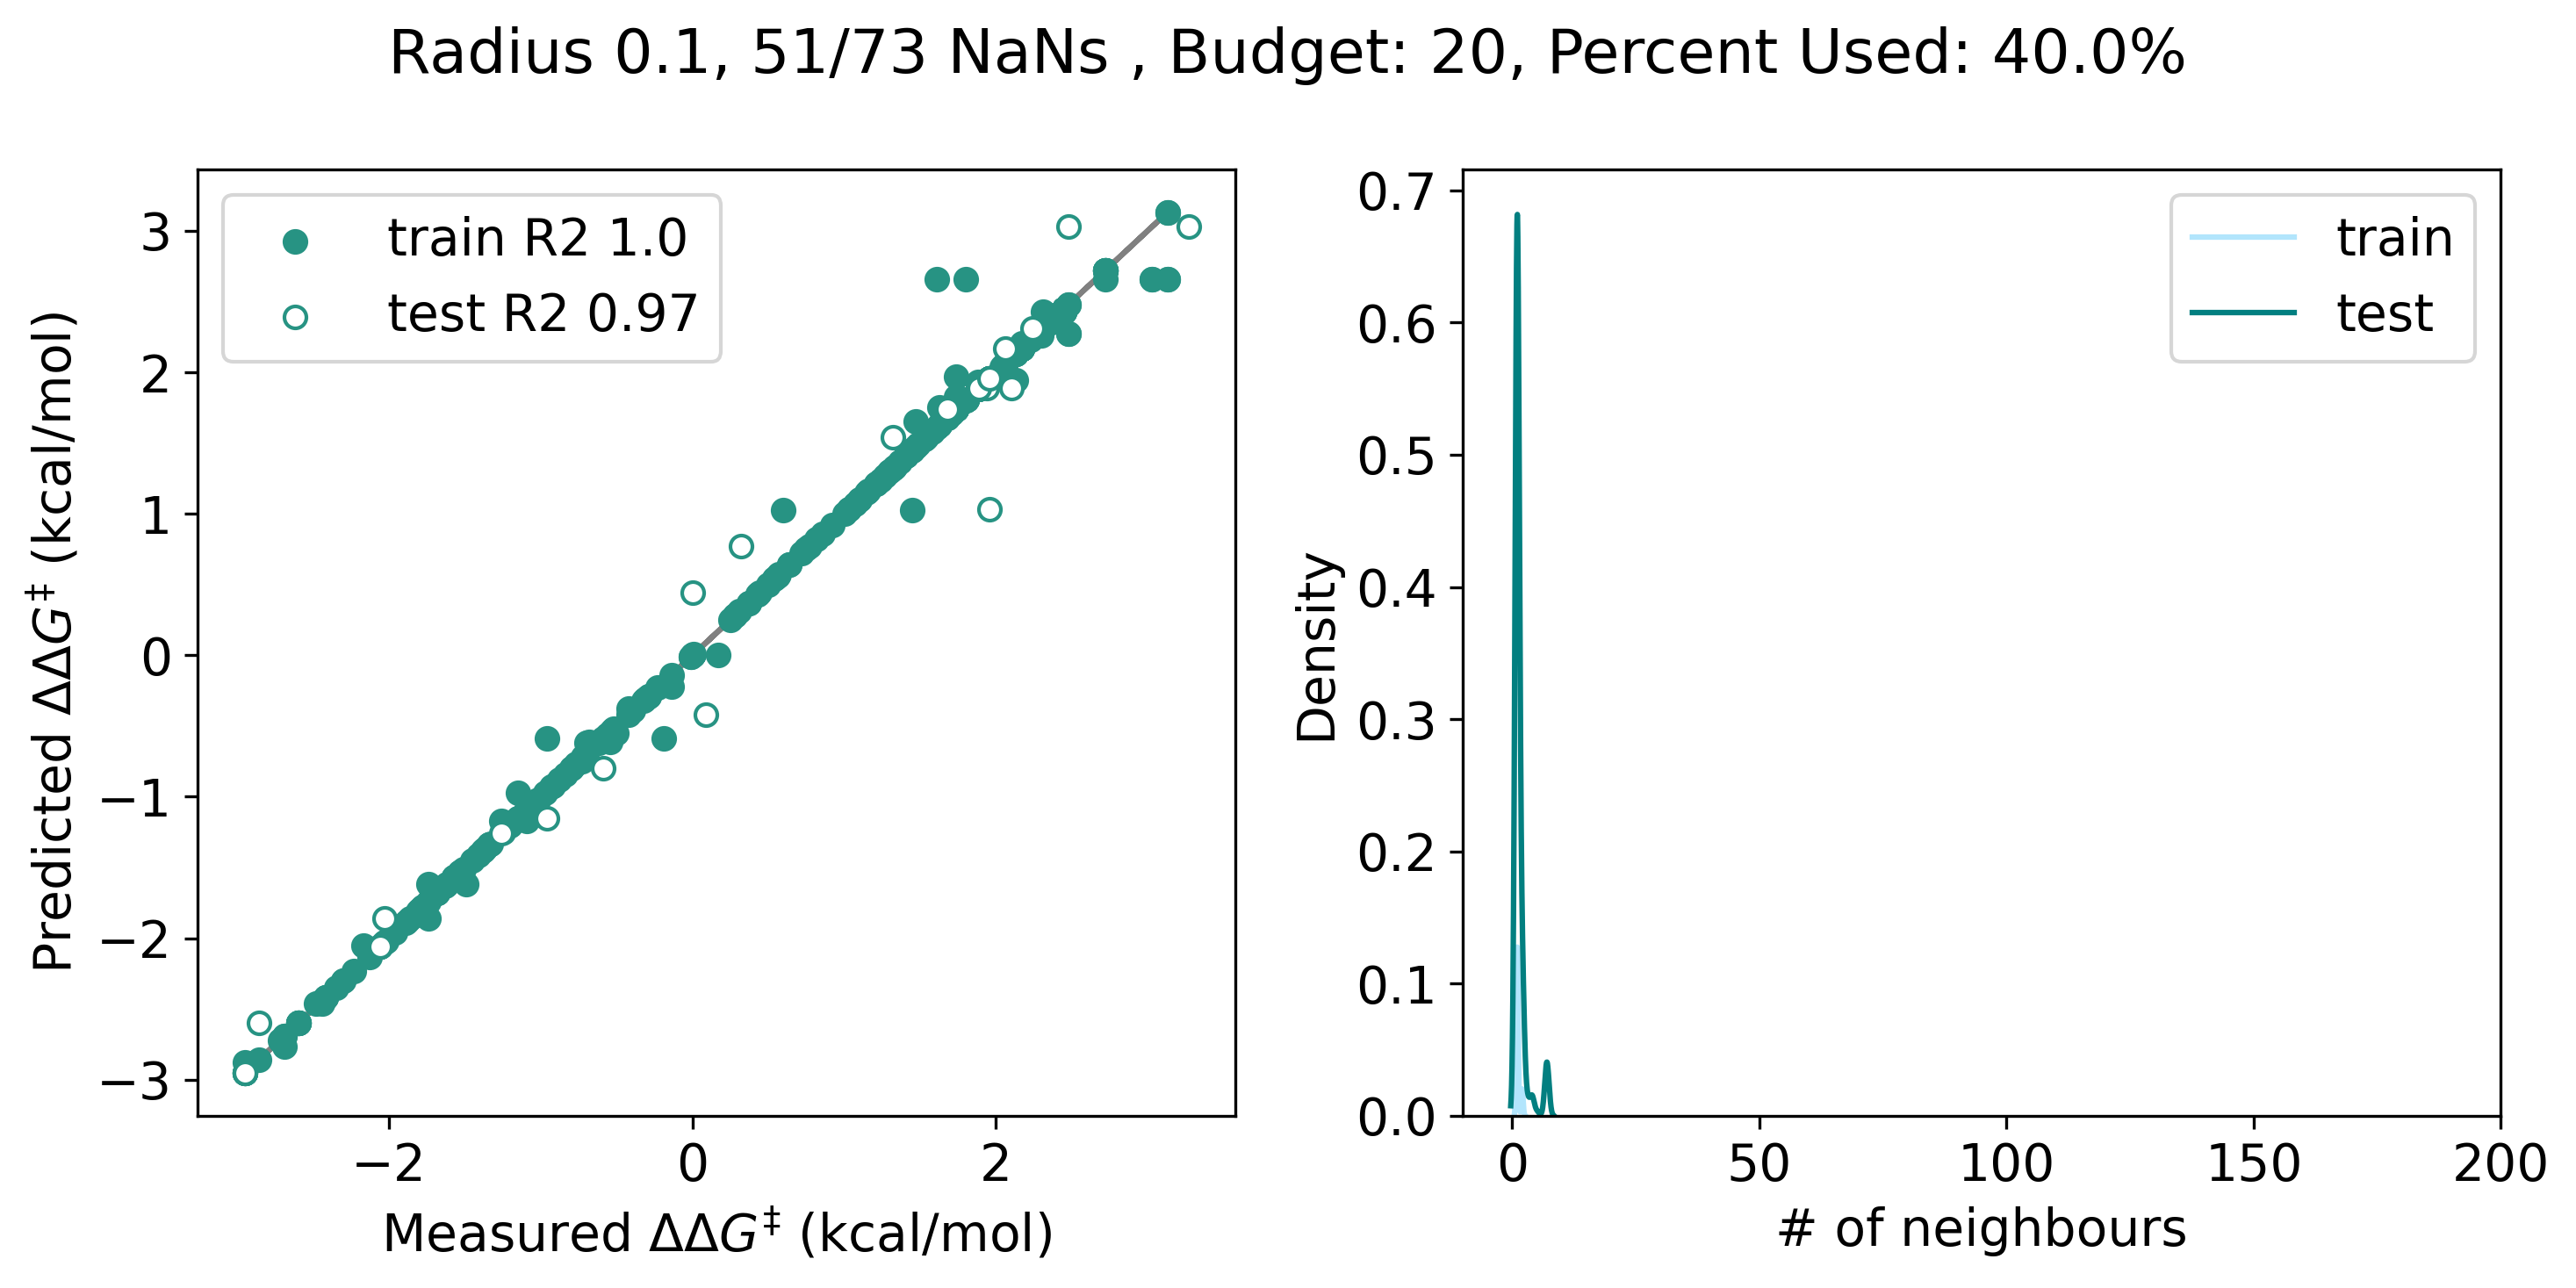

25


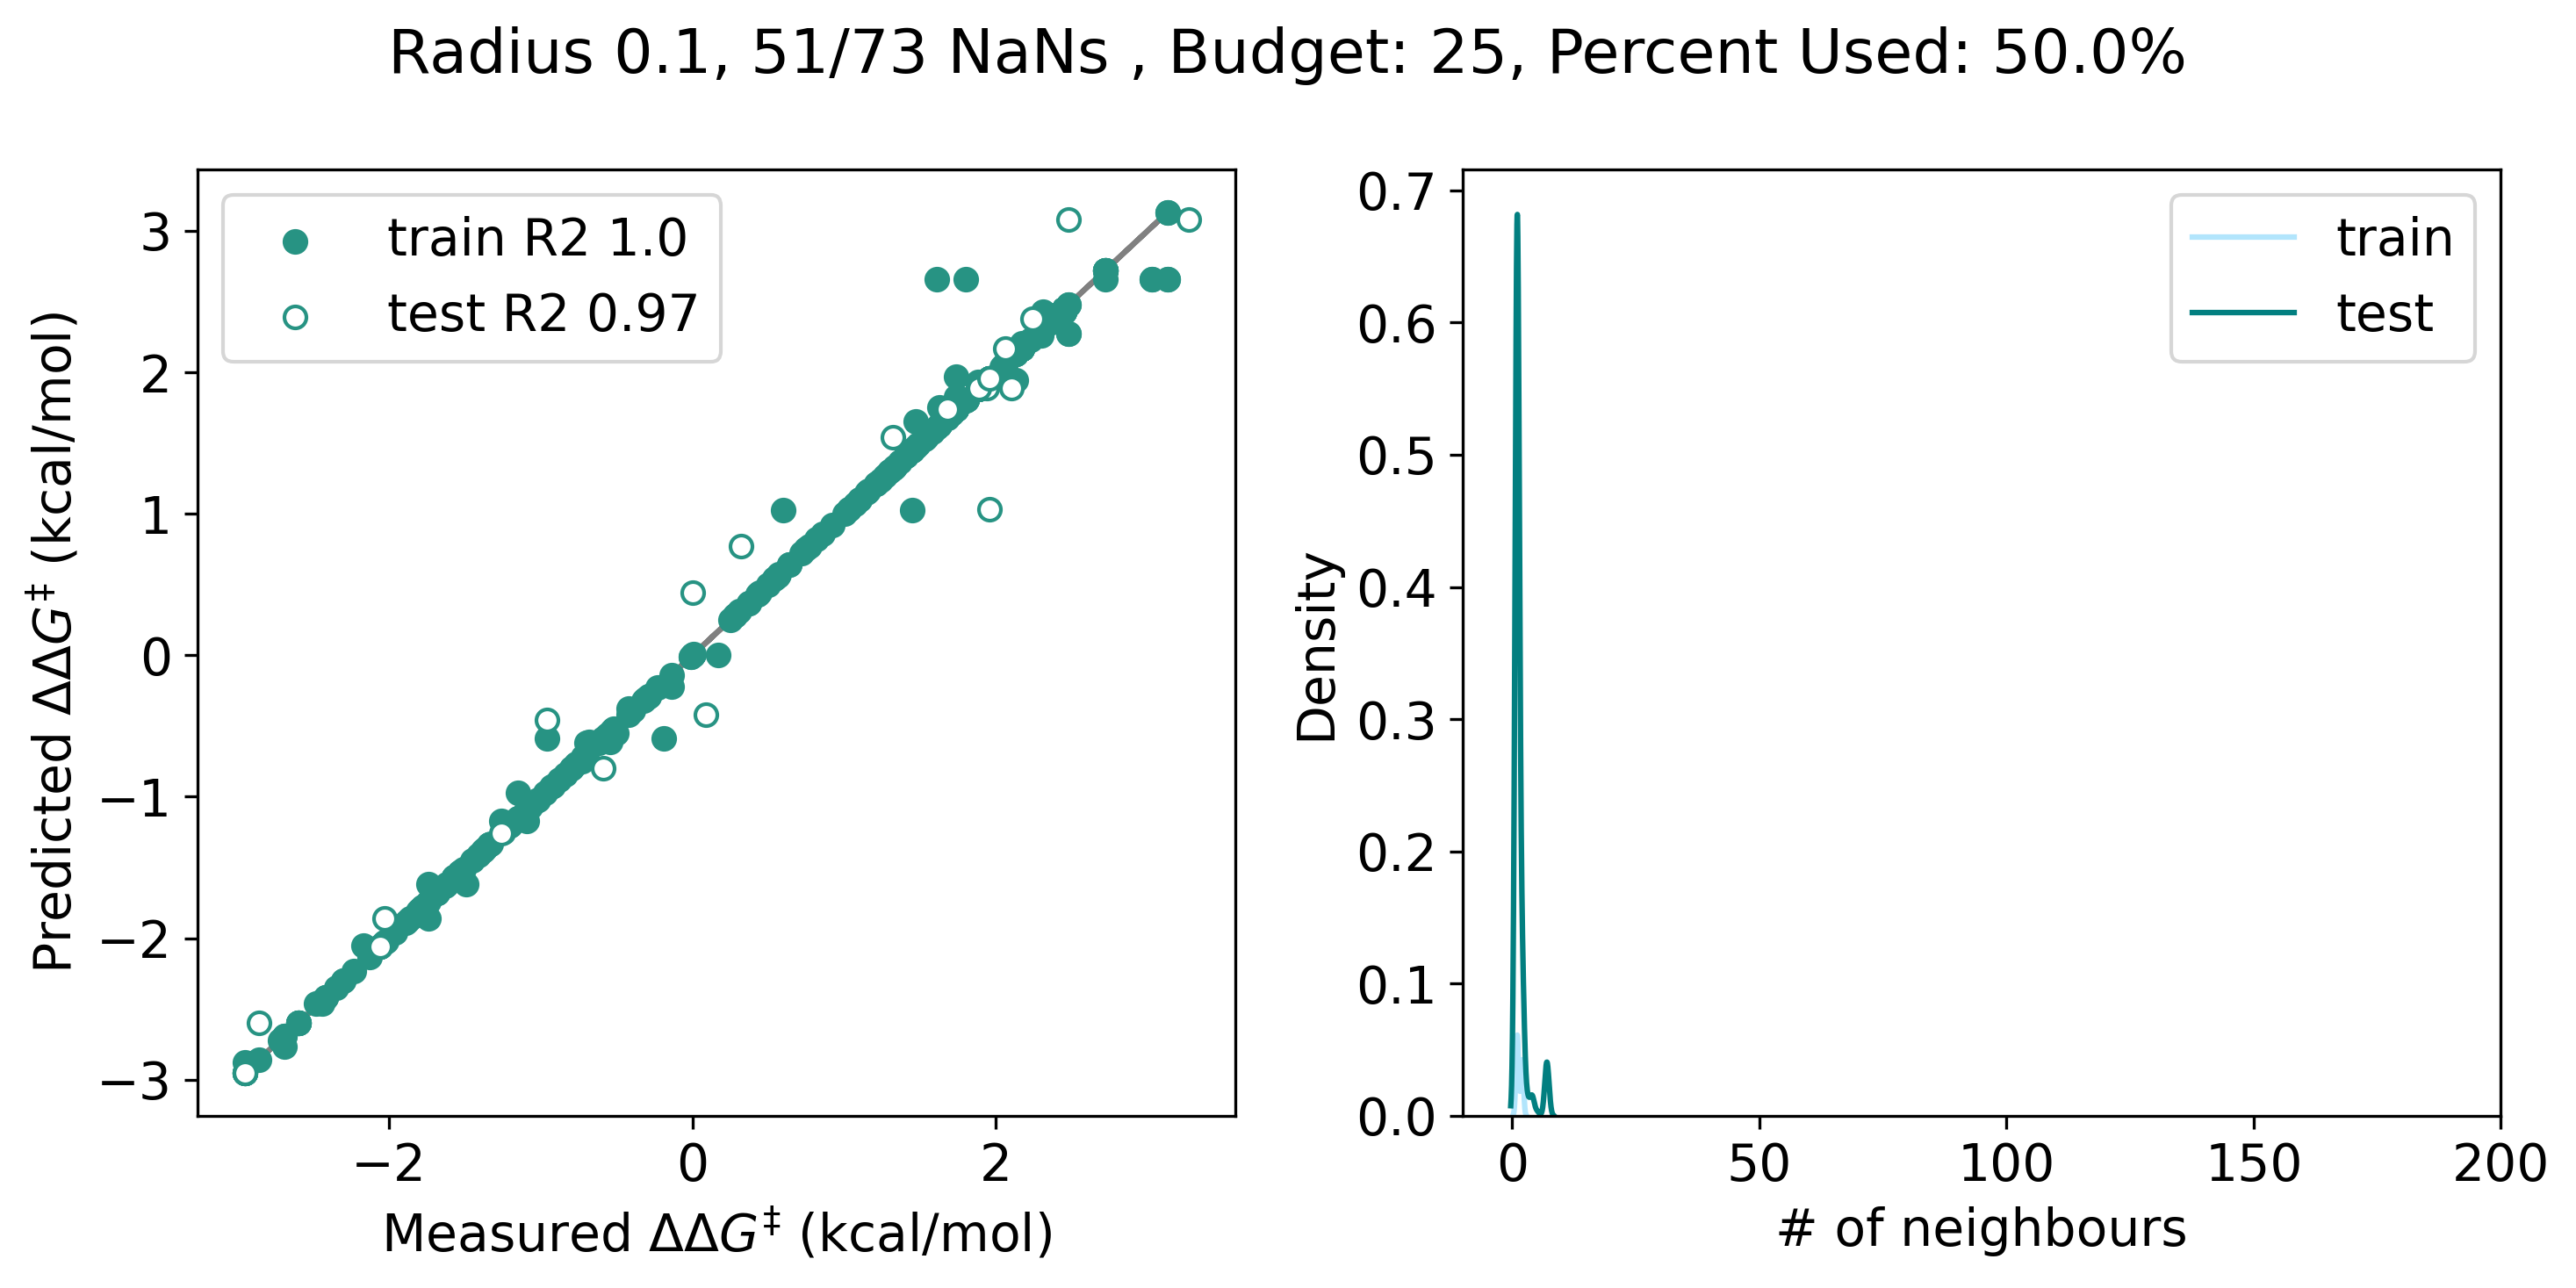

30


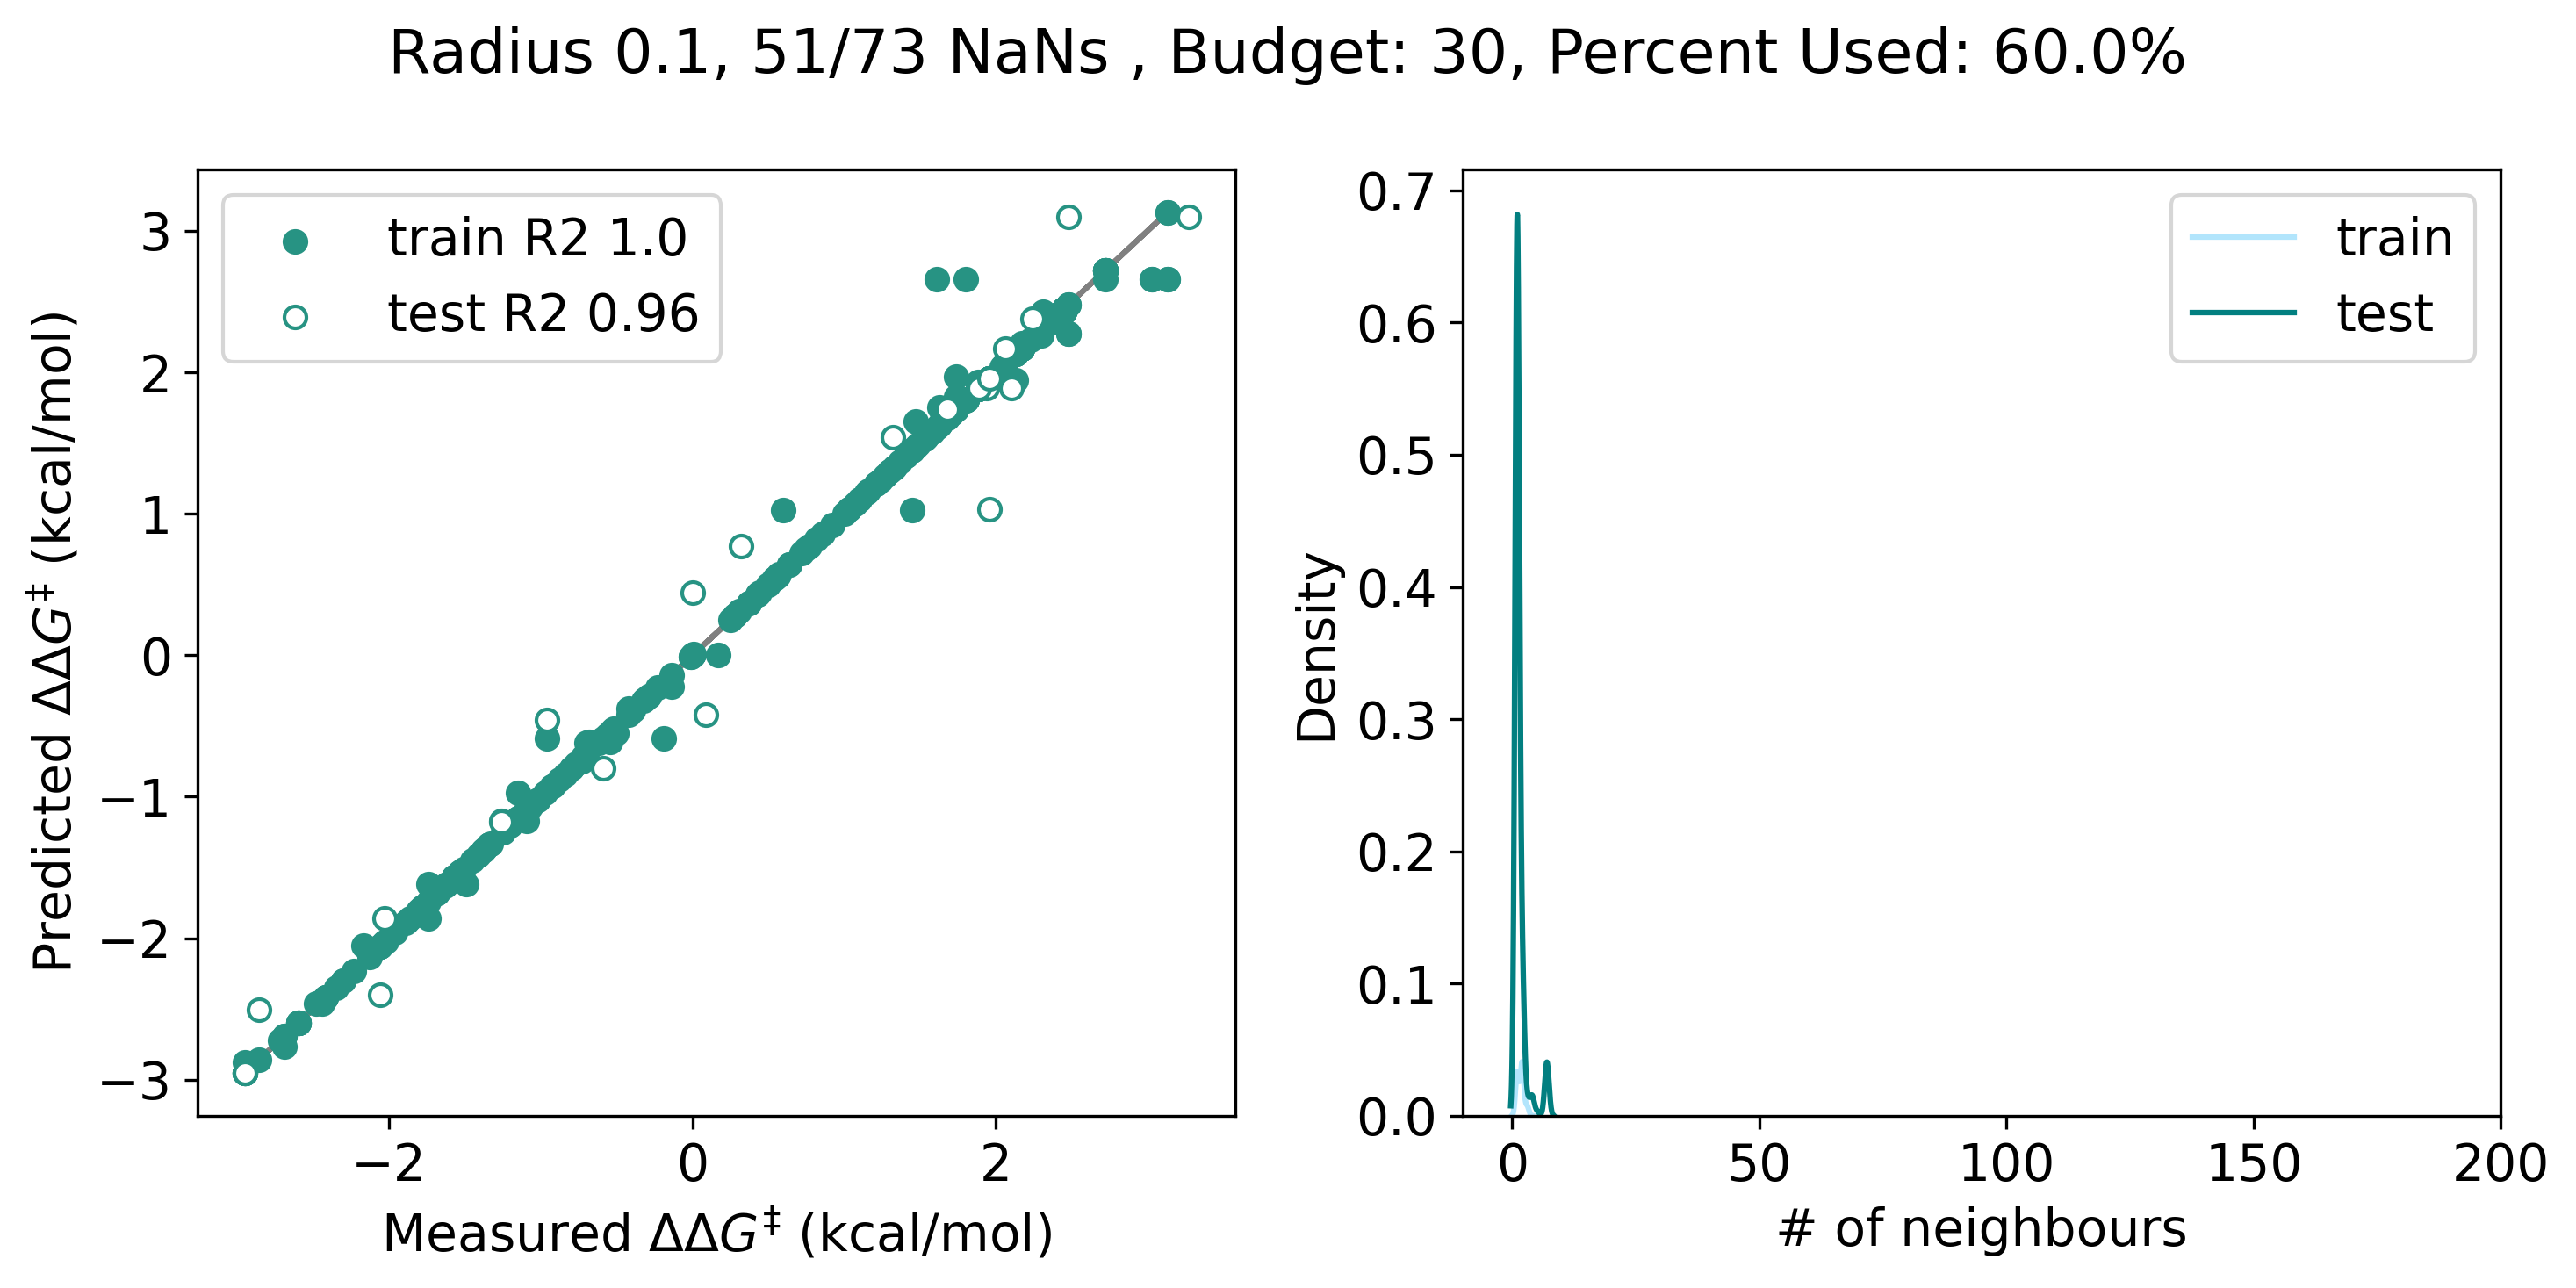

35


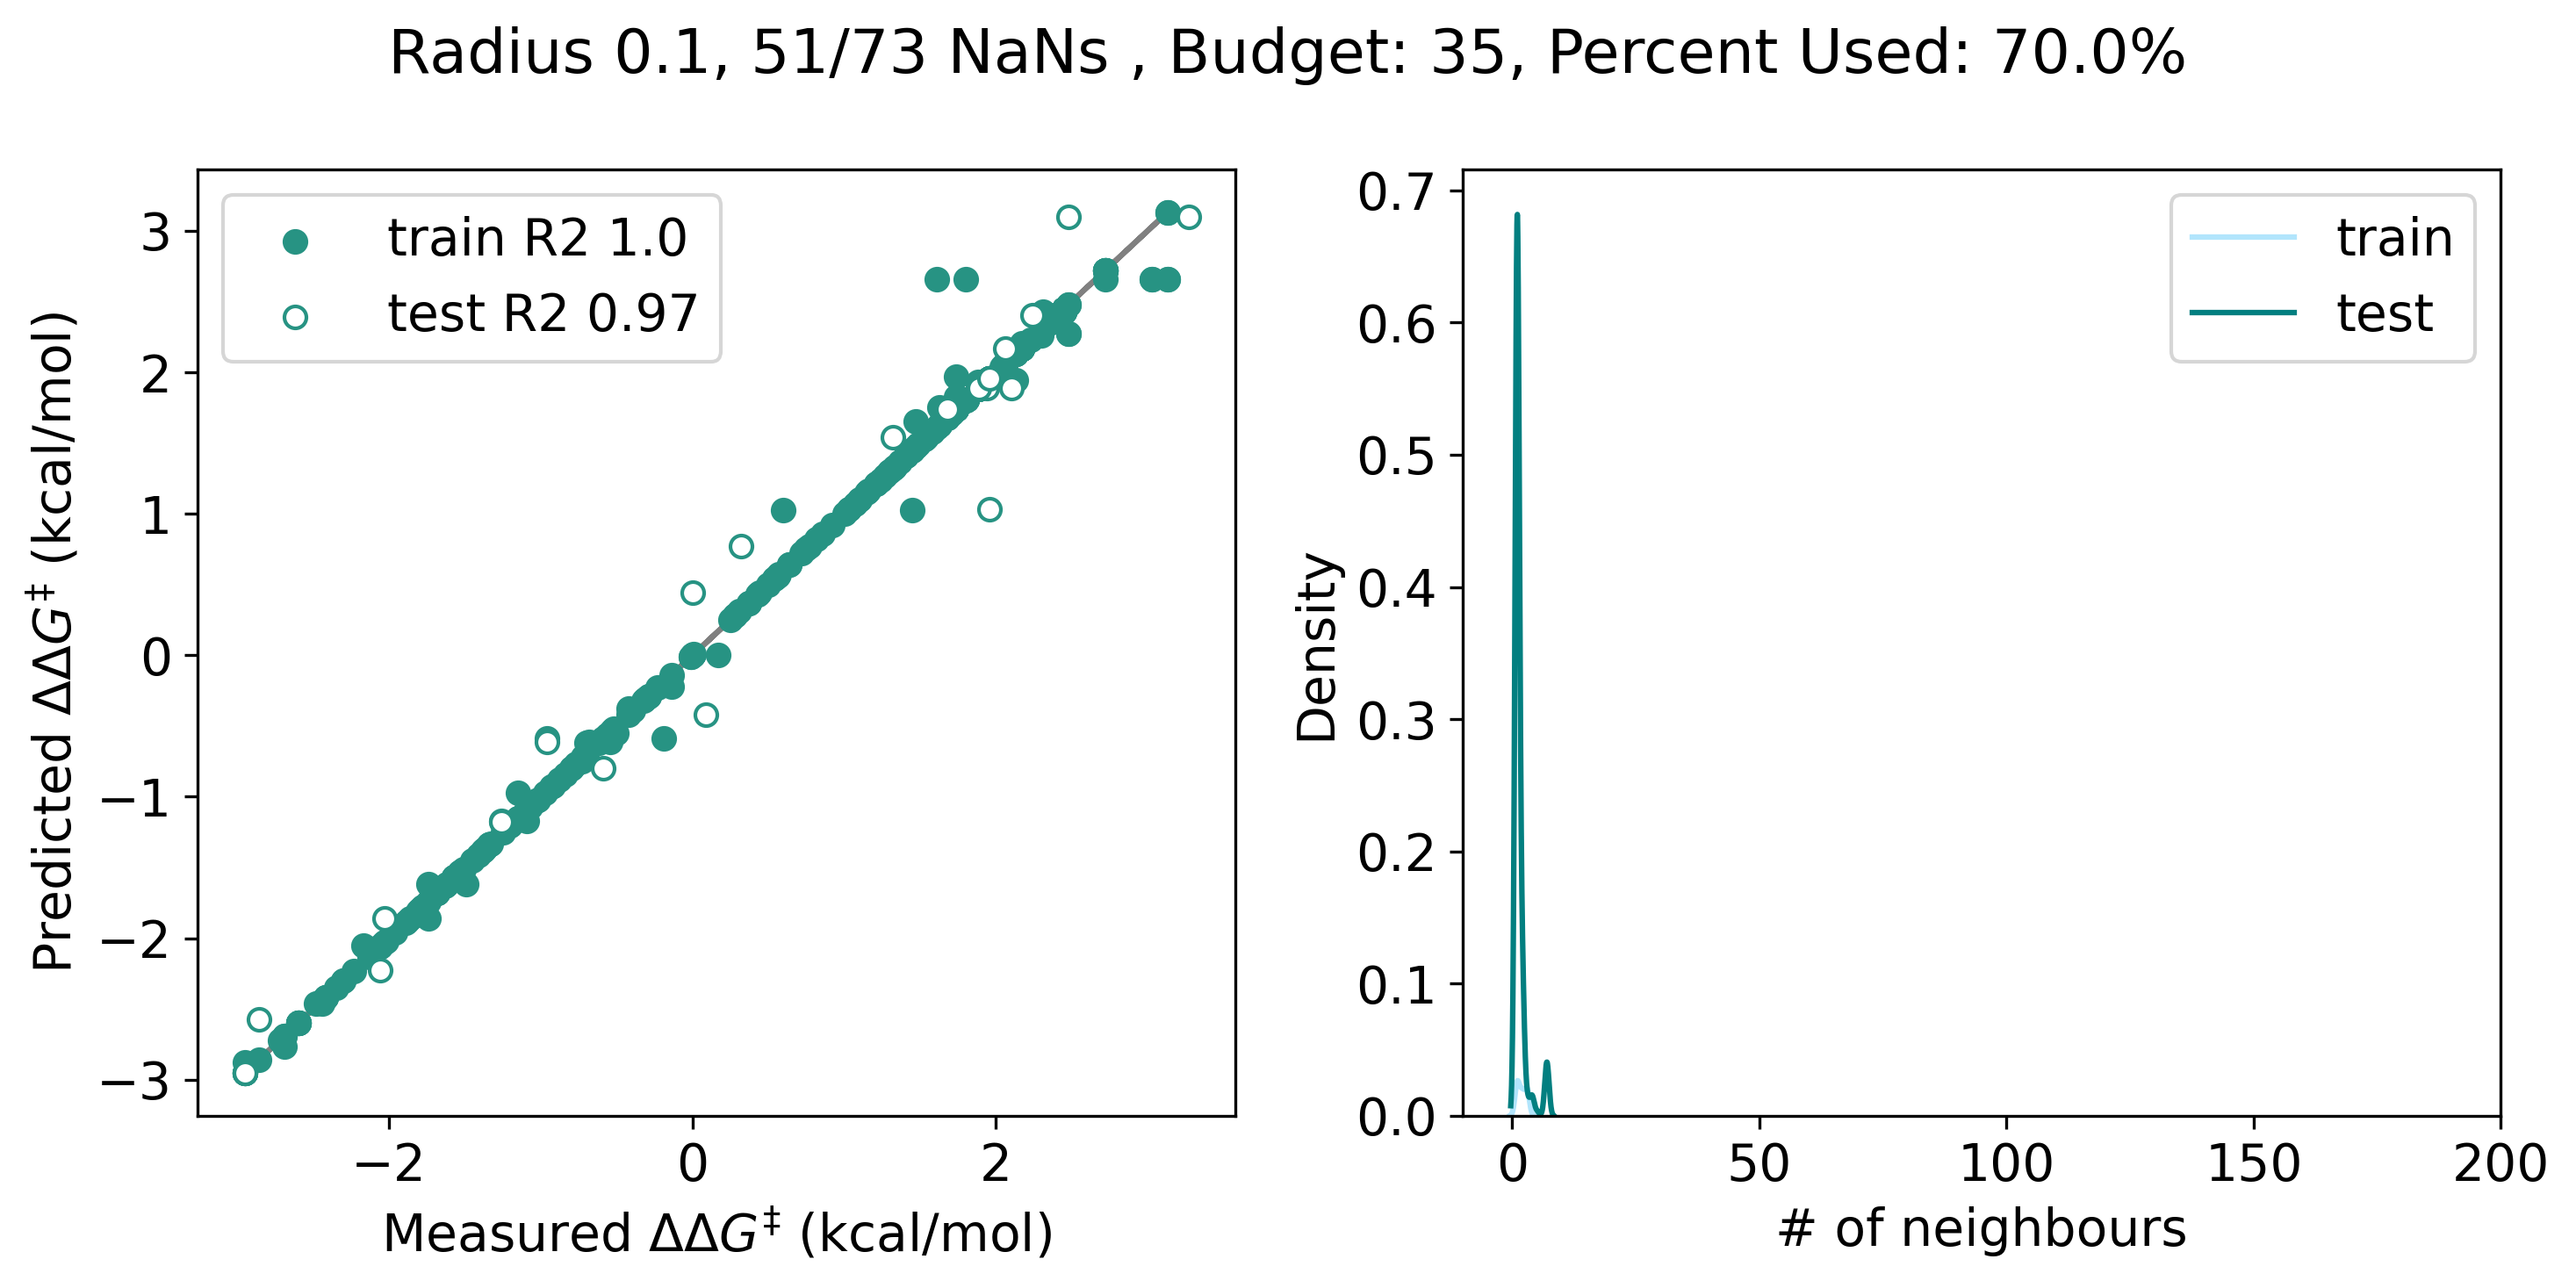

40


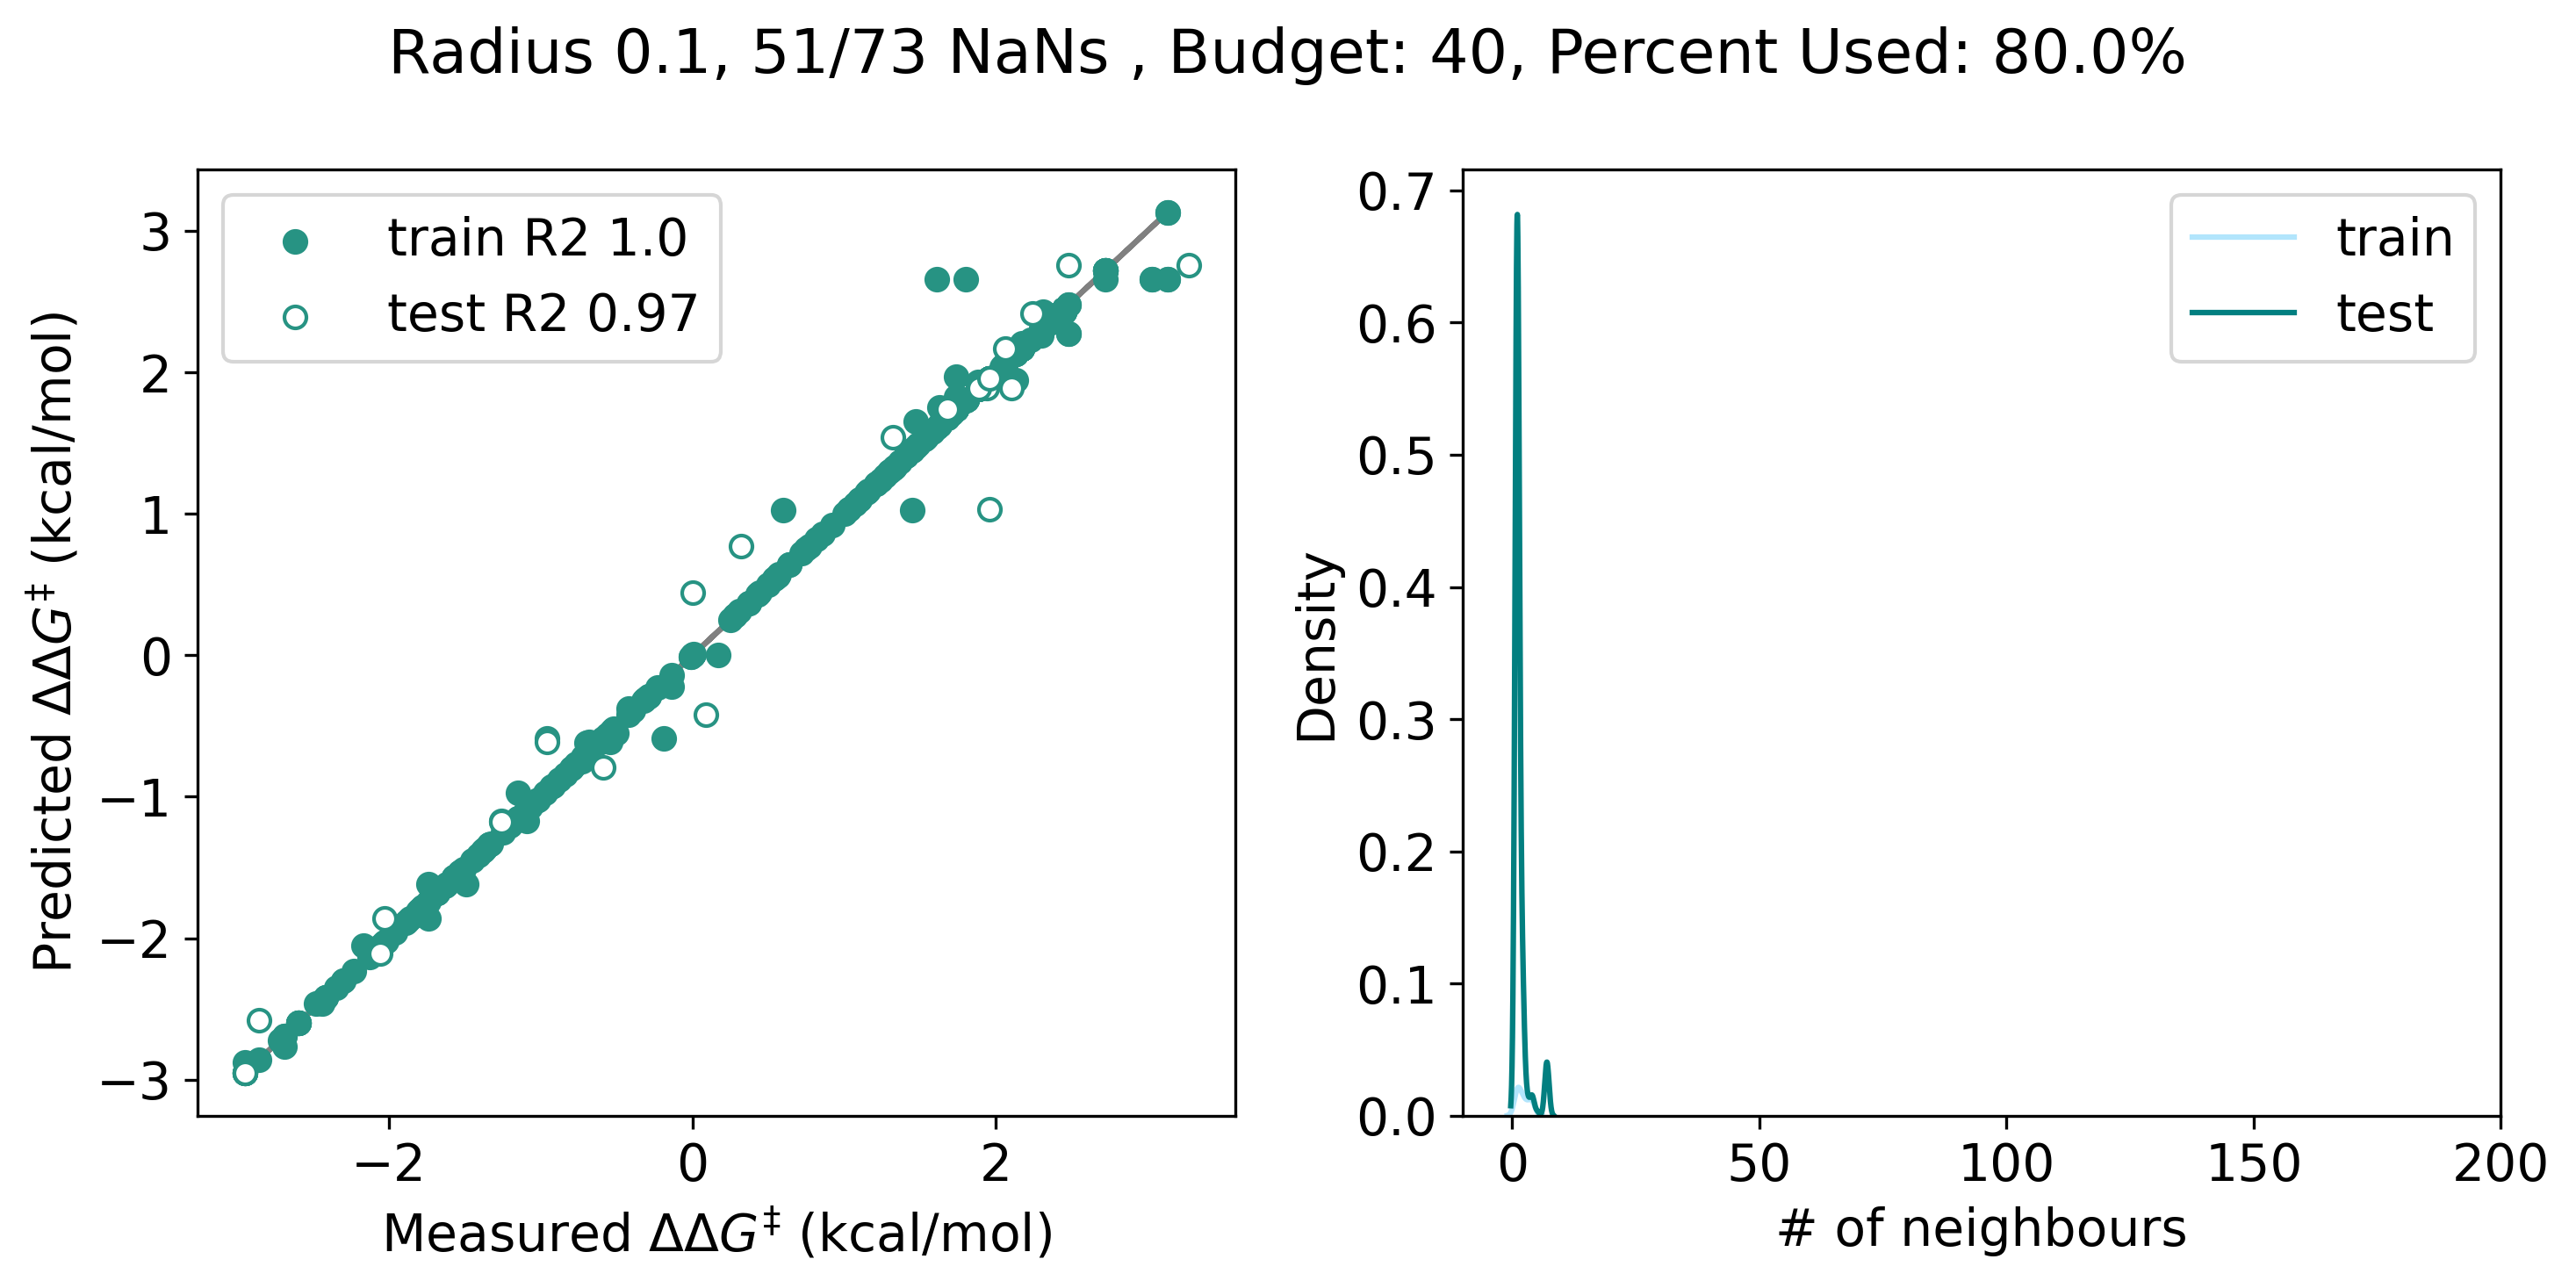

45


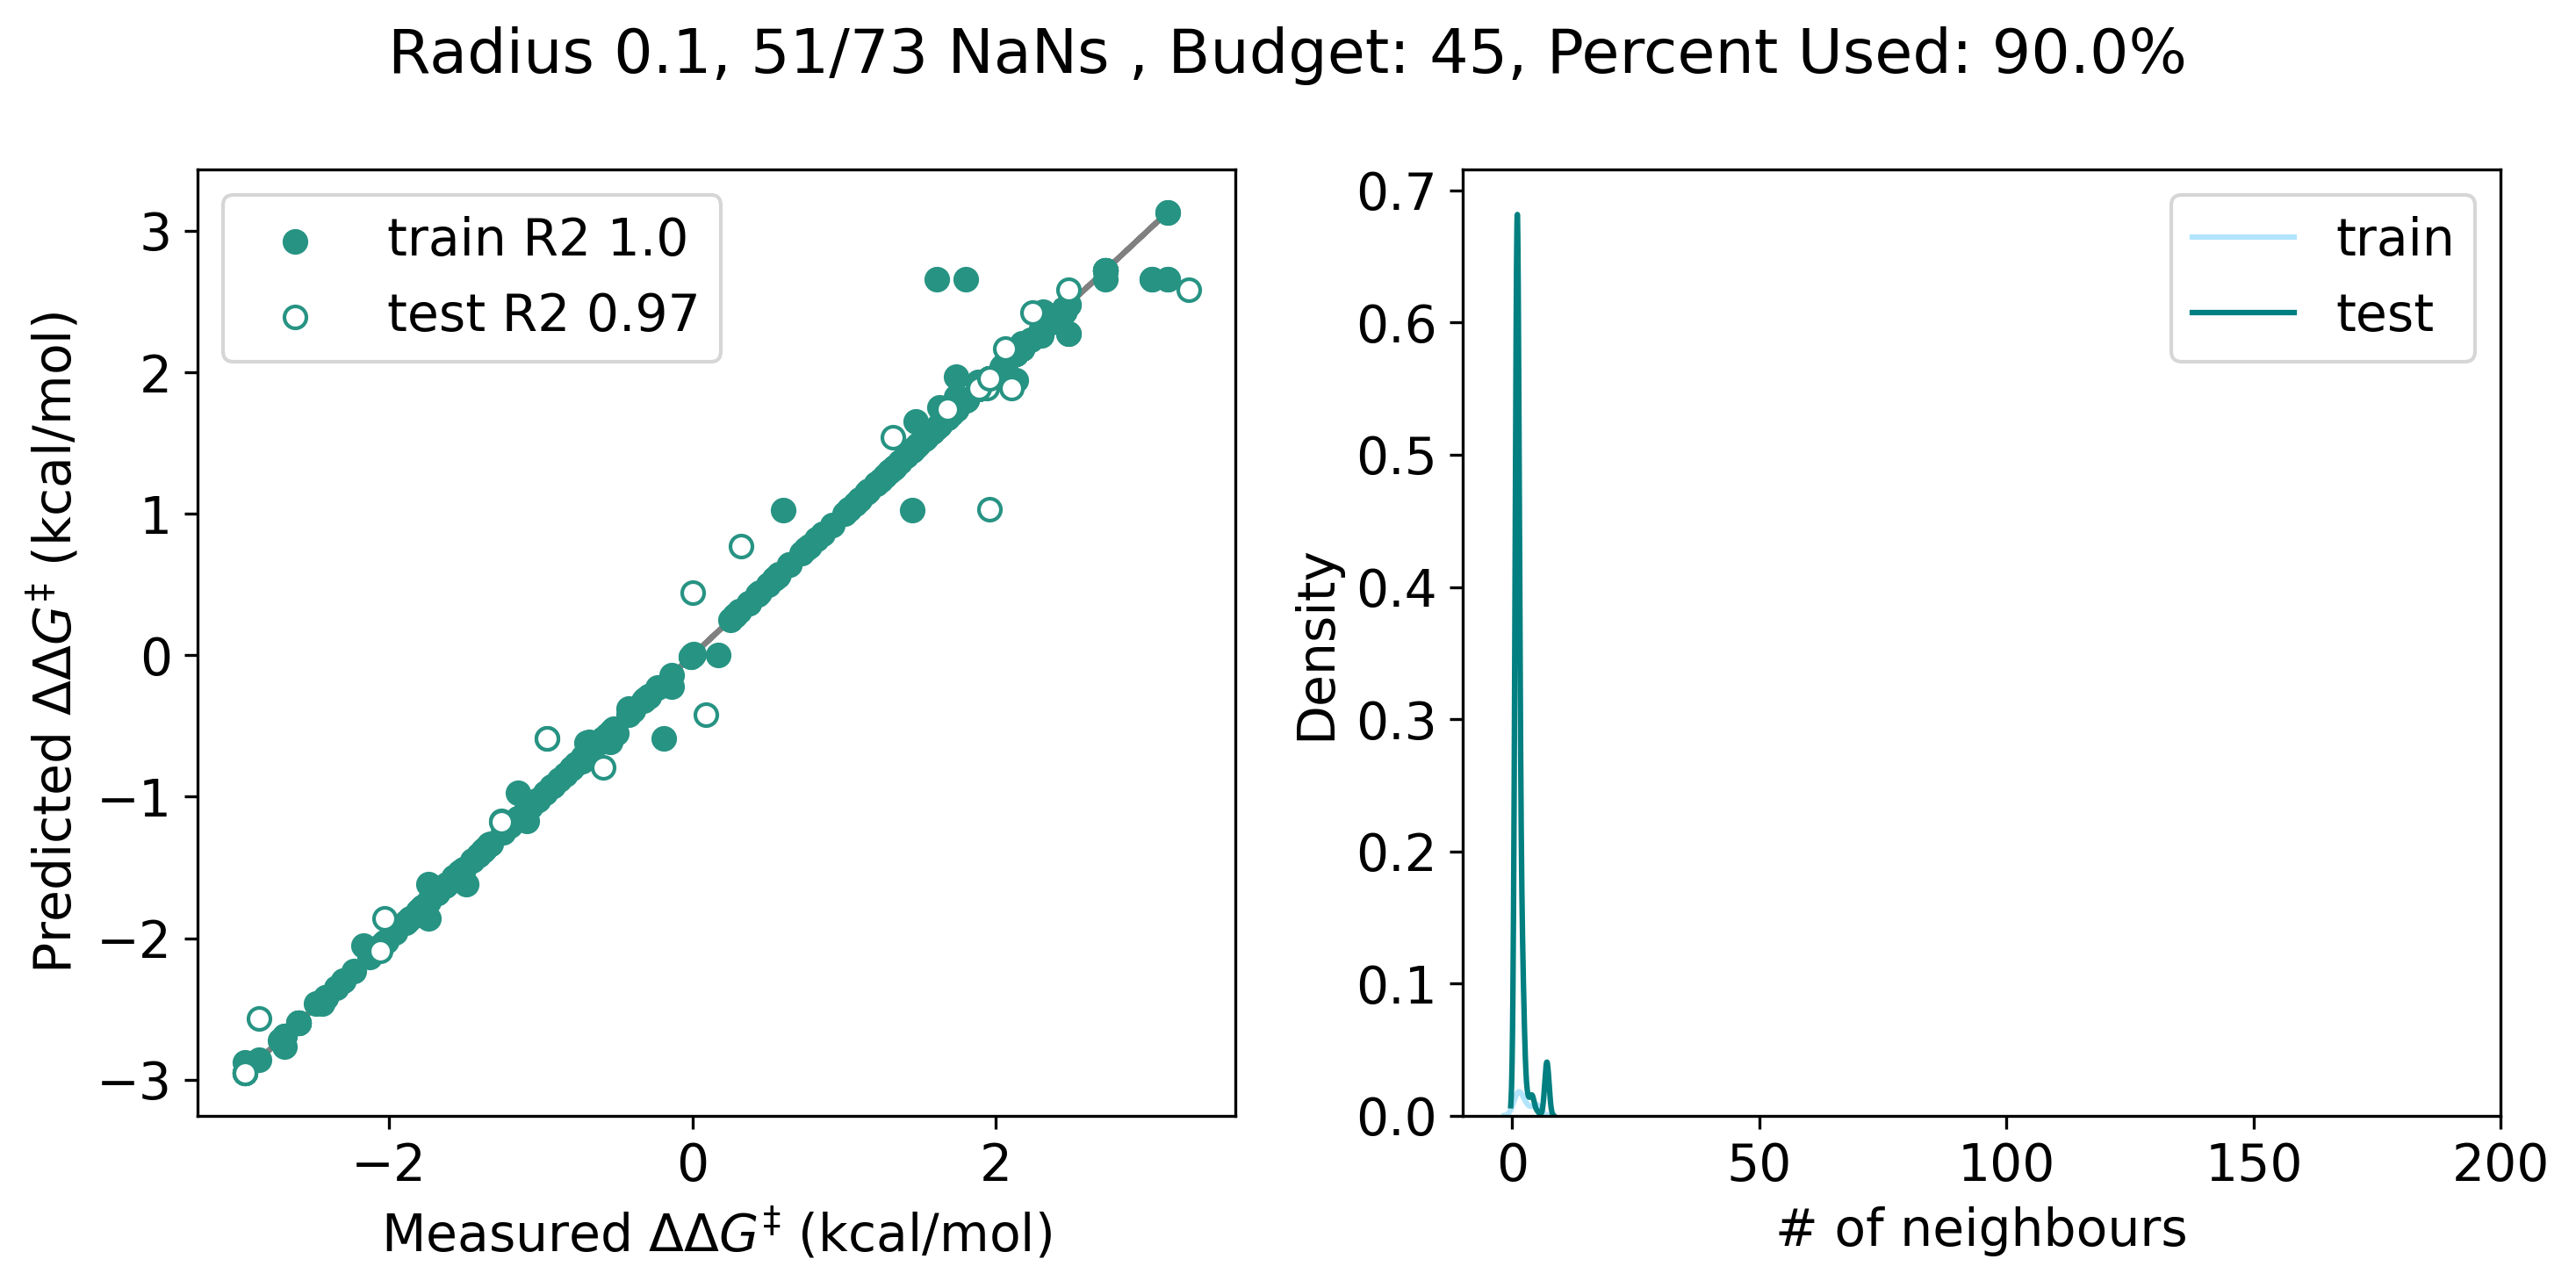

50


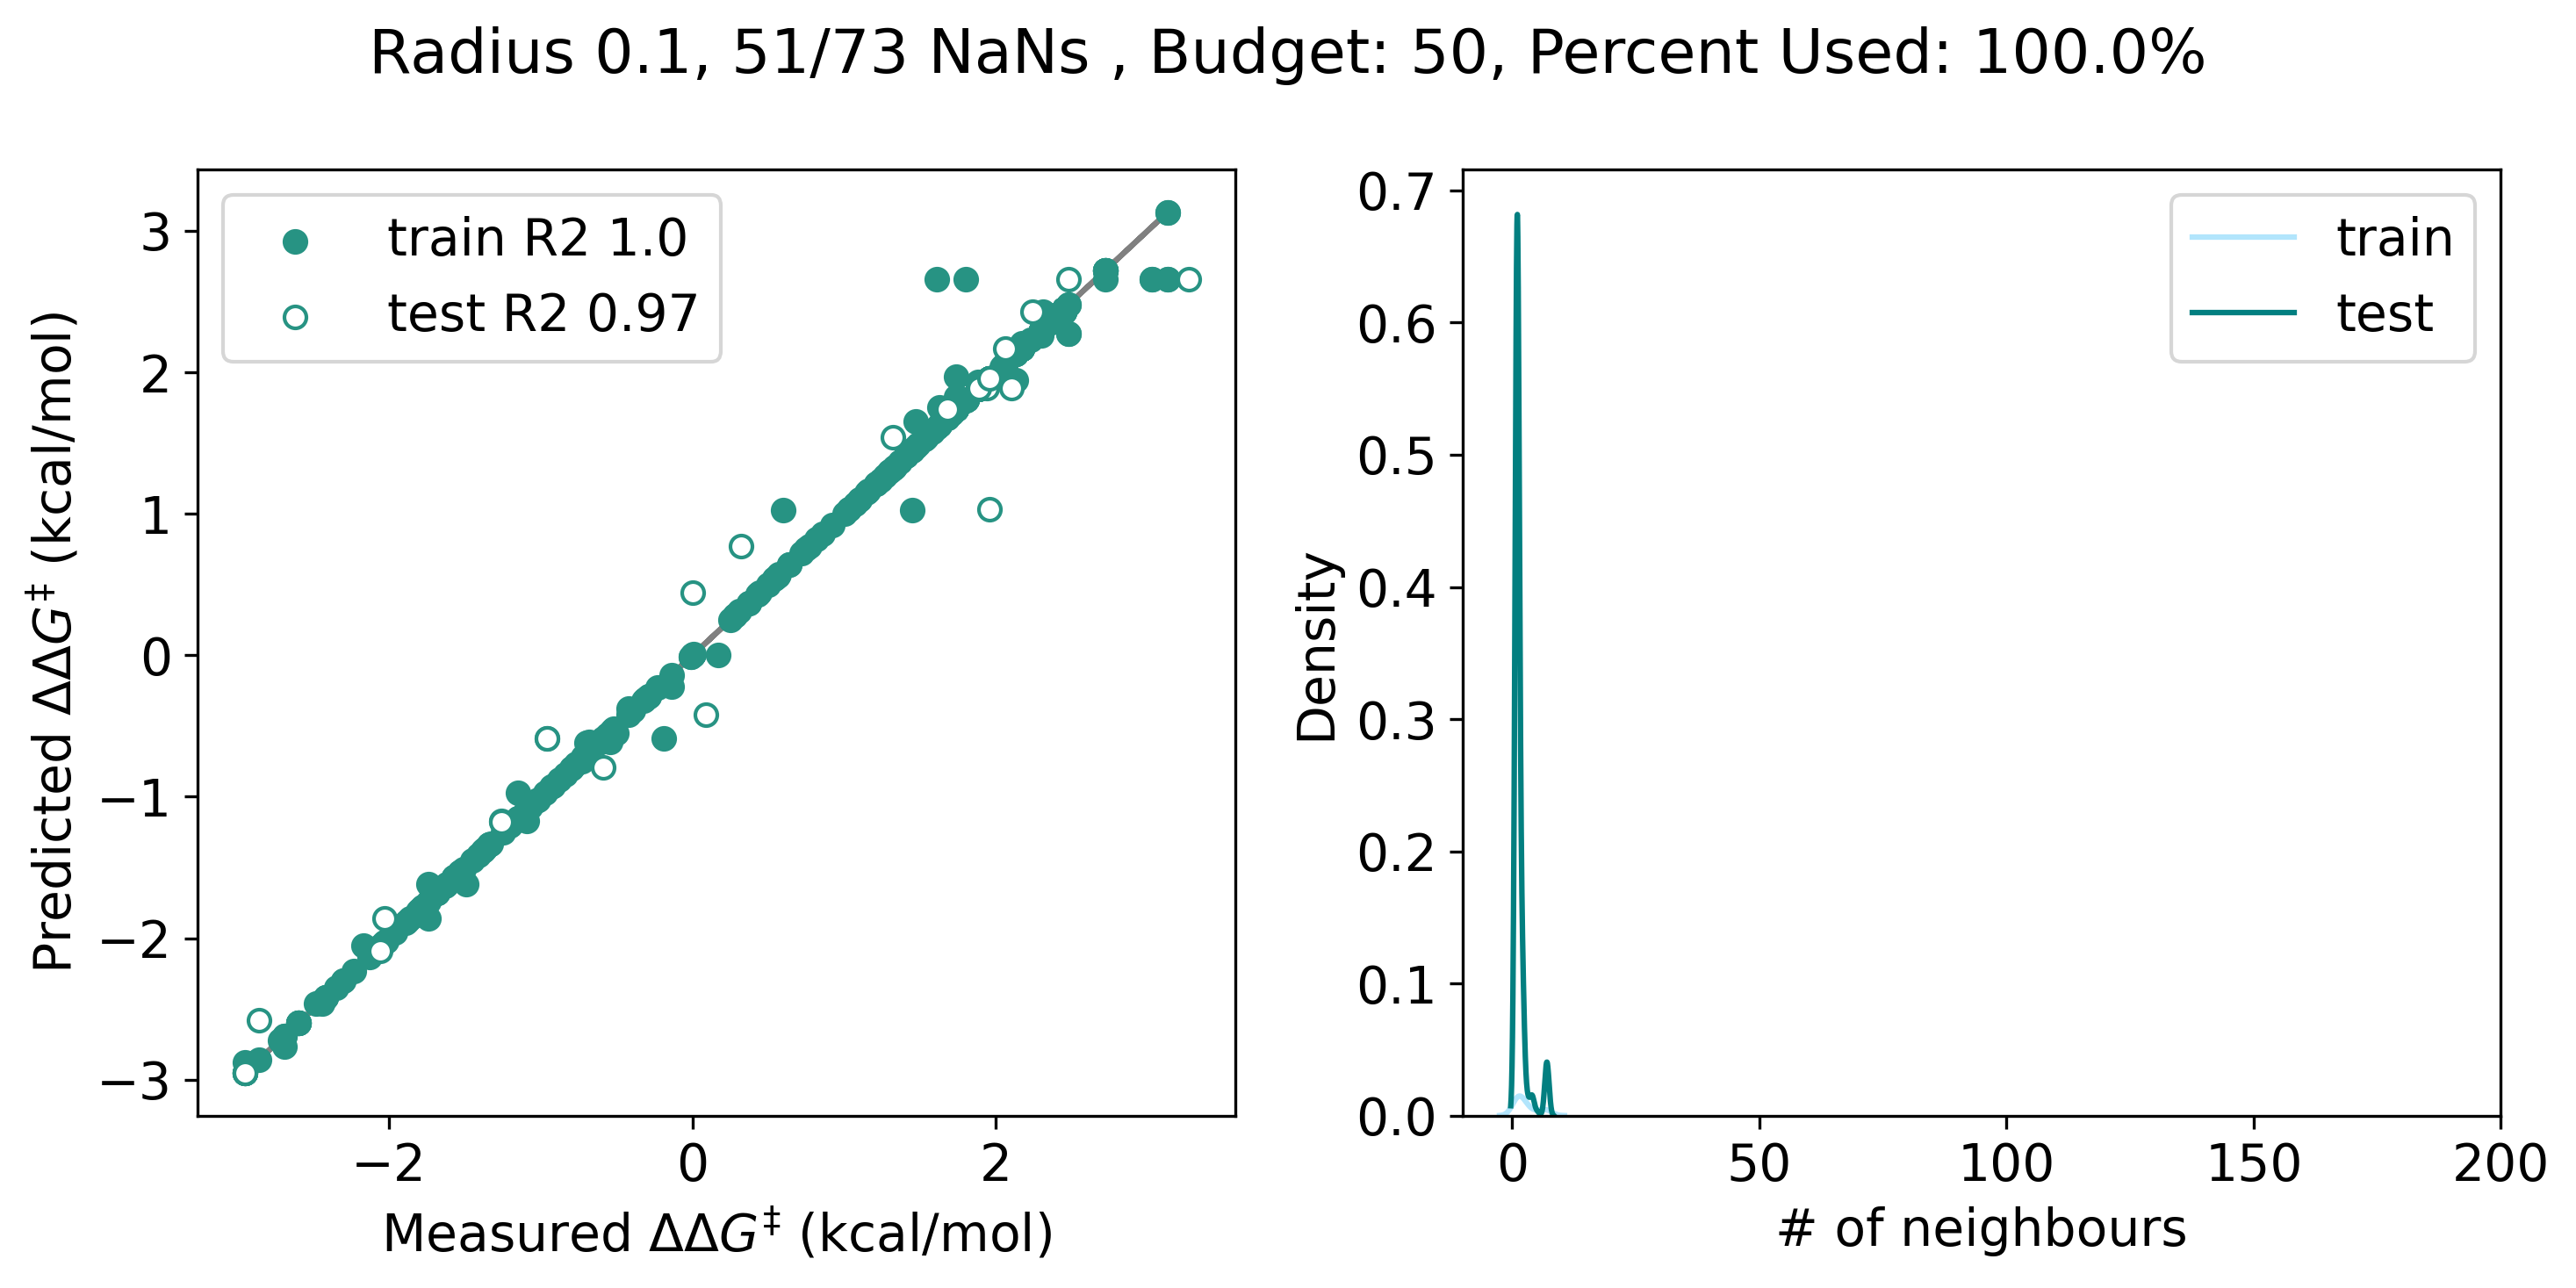

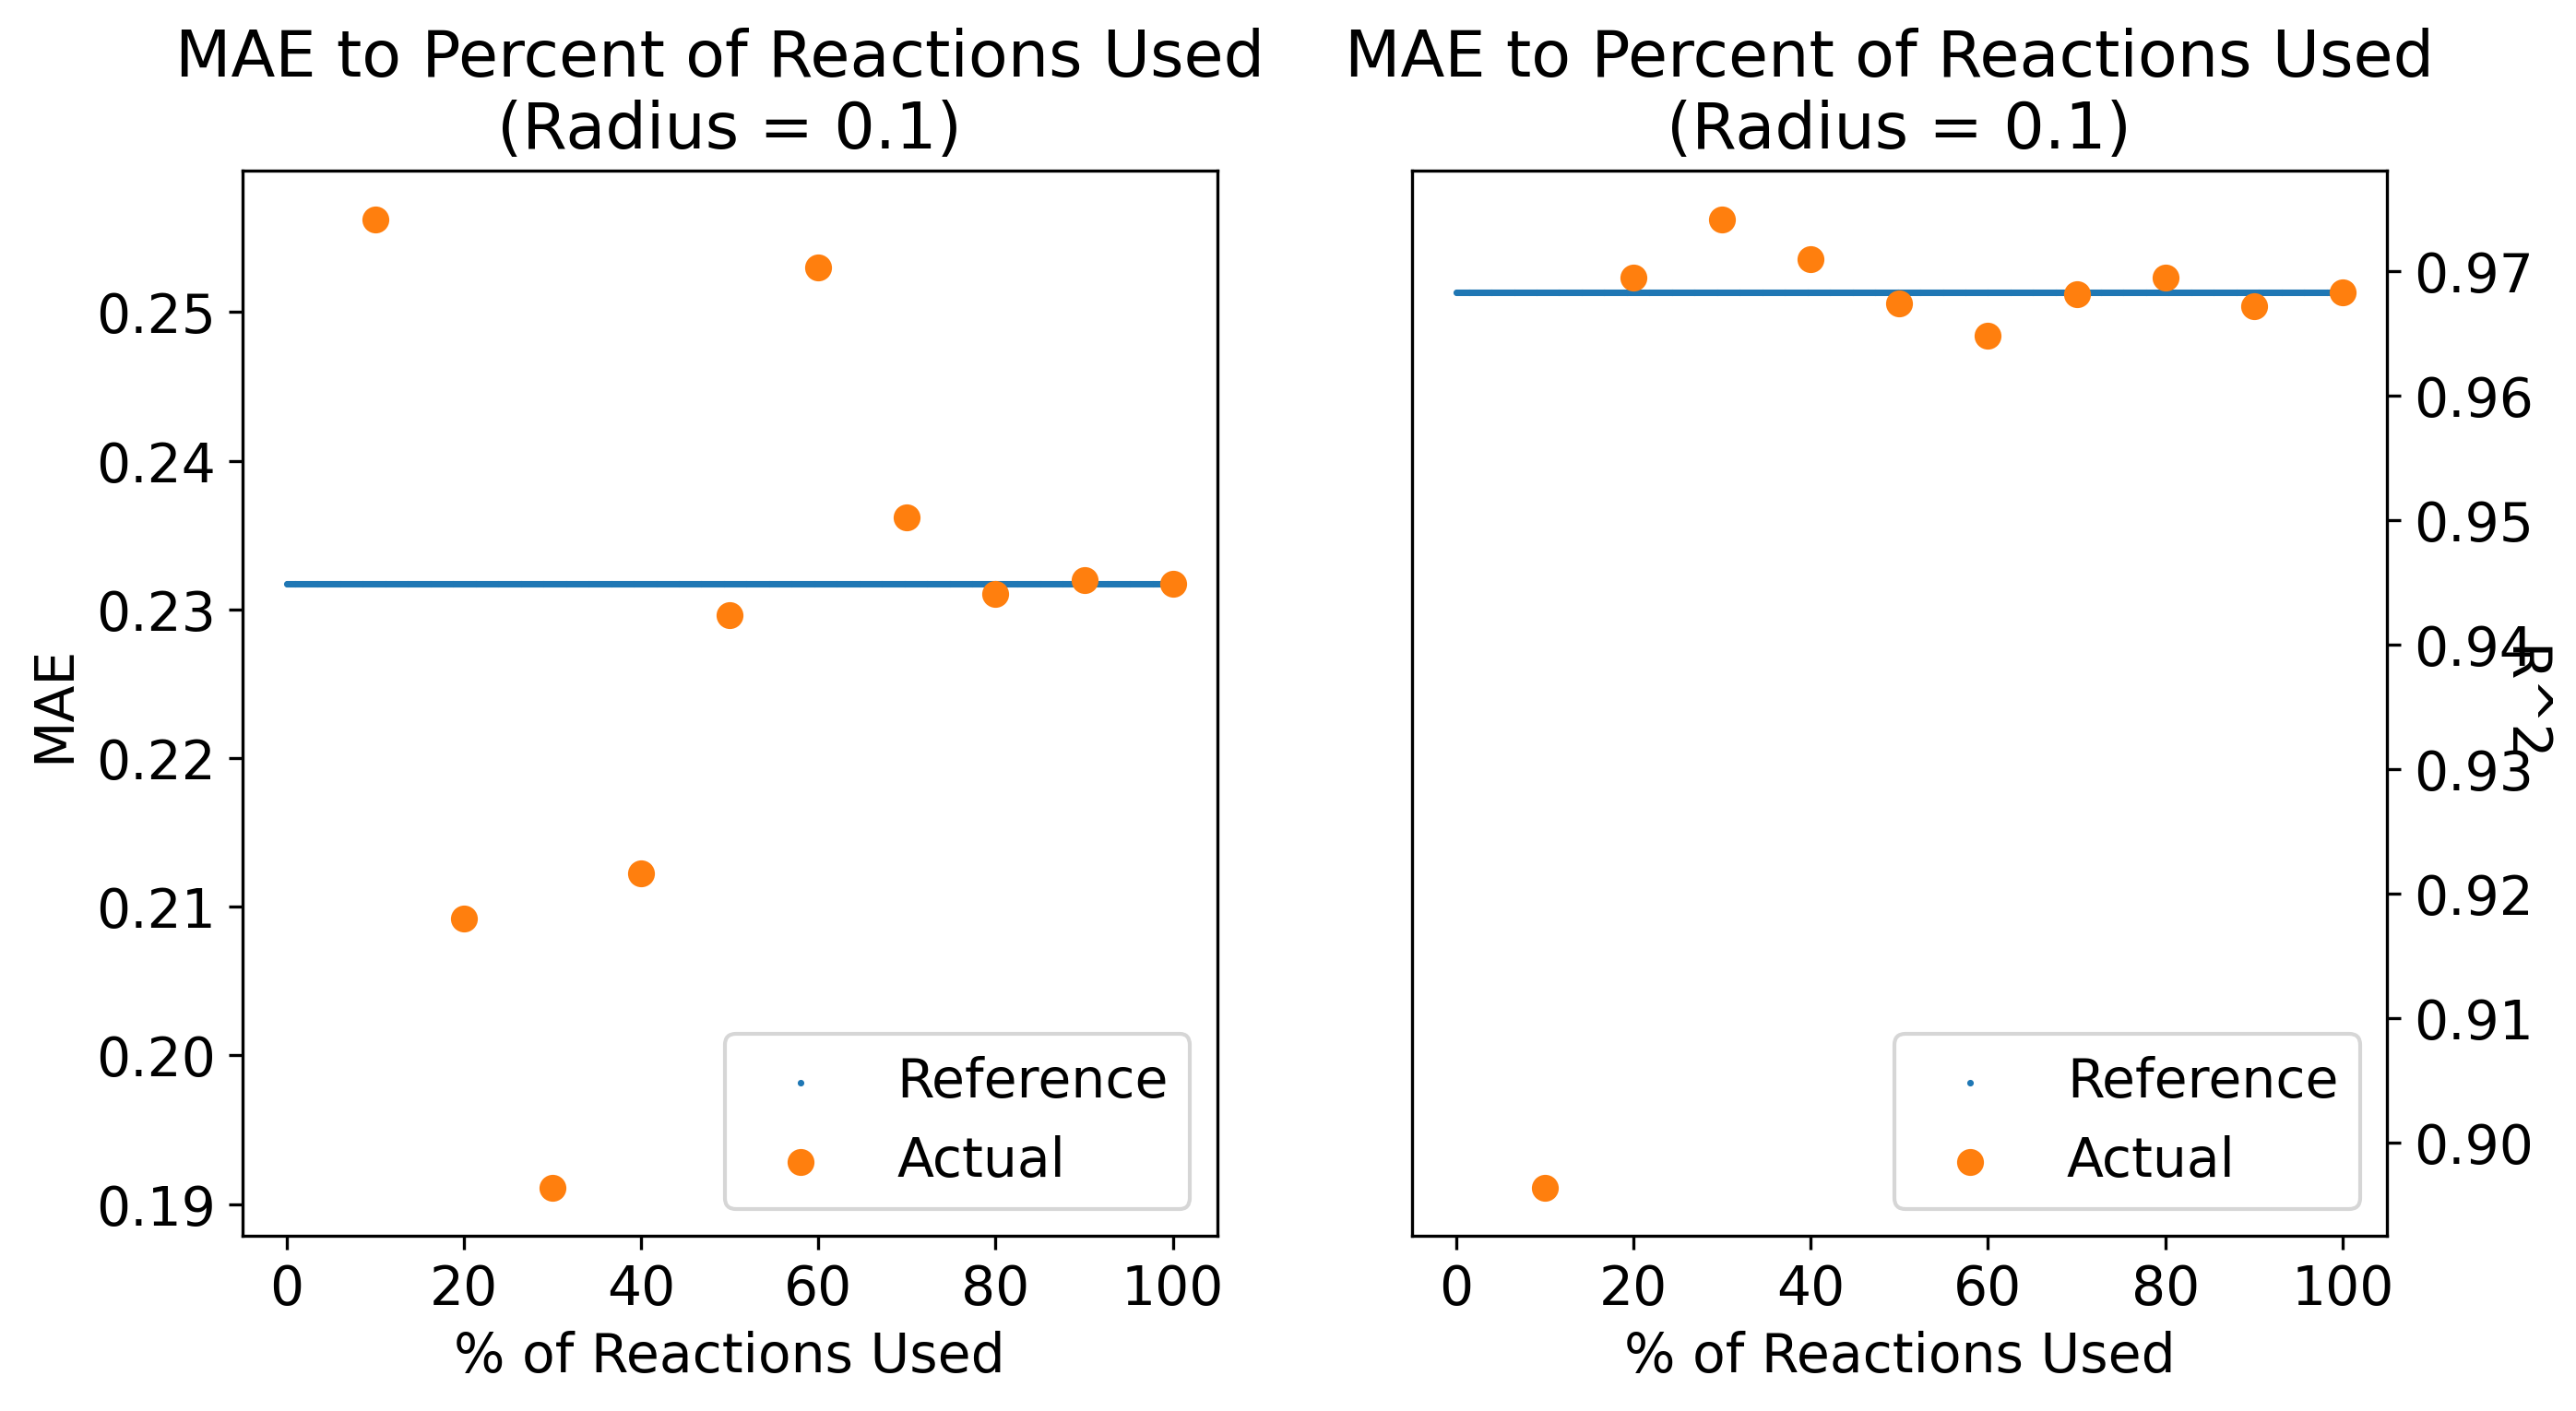

(0.9683101130524743, 0.9645146635571538, 0.96011290276683, 0.957437461905222, 0.9556536418551996, 0.9498721872366698, 0.9515944366906215, 0.9494713052724154, 0.9463171122025106)


In [12]:
i = 0
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i])

In [13]:
RaRF_mae

(0.23173106060606144,
 0.23584534382284433,
 0.2500449059987635,
 0.2639002614964947,
 0.2632628004377665,
 0.26833797496643397,
 0.26812416315419774,
 0.276582794481014,
 0.26998162143032045)

In [ ]:
i = 1
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i])
#sorted neighbours is a little slow. Look at that later.

In [ ]:
i = 2
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i])

In [ ]:
i = 3
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i])

In [ ]:
i = 4
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i])

In [ ]:
i = 5
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i])